In [2]:
# import sys
# 
# from tests.smoke_tests.olesik_et_al_2022.test_simulation import settings
# 
# if 'google.colab' in sys.modules:
#     !pip --quiet install open-atmos-jupyter-utils
#     from open_atmos_jupyter_utils import pip_install_on_colab
#     pip_install_on_colab('PyMPDATA-examples')

In [1]:
import matplotlib.pyplot as plt

# import os
# os.environ["NUMBA_DISABLE_JIT"] = "1"

from asian_option import AsianArithmetic, Settings, plot_solution, plot_difference_arithmetic

import numpy as np
from matplotlib import pyplot
from ipywidgets import IntProgress
from tqdm import tqdm

from open_atmos_jupyter_utils import show_plot, show_anim
from monte_carlo import BSModel, FixedStrikeGeometricAsianOption, FixedStrikeArithmeticAsianOption
import time
from PyMPDATA_examples.utils.financial_formulae import (
    Bjerksund_and_Stensland_1993,
    Black_Scholes_1973,
)
import PyMPDATA_examples.utils.financial_formulae.asian_option as asian_analytic

In [2]:
def plot_solution(
    settings,
    frame_index,
    ax,
    history,
    S_linspace,
    arithmetic_by_mc,
    option_type: str,
    variant,
    A_space,
    S_space
):
    params = {
        k: v for k, v in settings.params.__dict__.items() if not k.startswith("K")
    }
    if variant == "call":
        BS_price_func = Black_Scholes_1973.c_euro
        Amer_price_func = Bjerksund_and_Stensland_1993.c_amer
        geometric_price_func = asian_analytic.geometric_asian_average_price_c
    else:
        BS_price_func = Black_Scholes_1973.p_euro
        Amer_price_func = Bjerksund_and_Stensland_1993.p_amer
        geometric_price_func = asian_analytic.geometric_asian_average_price_p

    ax.plot(
        S_linspace,
        (
            BS_price_func(
                S=S_linspace, K=settings.params.K, **params, b=settings.params.r
            )
        ),
        label="European analytic (Black-Scholes '73)",
        linestyle="--",
        alpha=0.5,
    )
    # ax.plot(
    #     S_linspace,
    #     (
    #         Amer_price_func(
    #             S=S_linspace, K=settings.params.K, **params, b=settings.params.r
    #         )
    #     ),
    #     label="American analytic (Bjerksund & Stensland '93)", linestyle='--'
    # )
    ax.plot(
        S_linspace,
        (
            geometric_price_func(
                S=S_linspace, K=settings.params.K, **params, dividend_yield=0
            )
        ),
        label="Asian analytic (geometric, Kemna & Vorst 1990)",
        alpha=0.5,
        linestyle="--",
    )
    ax.plot(
        S_linspace,
        arithmetic_by_mc,
        label="Asian arithmetic by Monte-Carlo",
        linestyle=":",
    )
    ax.bar(
        settings.rh[:-1],
        history[frame_index][:, 0],
        width=settings.rh[1:] - settings.rh[:-1],
        label=f"MPDATA solution ({option_type})",
        marker=".",
    )
    ax.plot(
        A_space,
        history[0][0, :],
        label=f"Terminal condition (discounted payoff)",
        marker=".",
    )
    ax.legend(loc="upper right")
    ax.grid()
    minmax = (np.amin(history[0]), np.amax(history[0]))
    span = minmax[1] - minmax[0]
    ax.set_ylim(minmax[0] - 0.05 * span, minmax[1] + 0.25 * span)
    ax.set_title(f"instrument parameters: {settings.params.__dict__}")
    # ax.set_xlabel("underlying S(t=0)=A(t=0) (and A(T) for terminal condition)")
    ax.set_xlabel("average at t=T for payoff, spot at t=0 for other datasets")
    ax.set_ylabel("value")

In [73]:
def run_numeric_and_mc(params, nx=31, ny=41, nt=300, variant='call'):
    s_max = params.get('S_max', params['spot']*2)
    s_min = params.get('S_min', params['spot']/2)
    settings = Settings(T=params['T'], K=params['K'], r=params['r'], sgma=params['sgma'], S_max=s_max, S_min=s_min)
    simulation = AsianArithmetic(settings, nx=nx, ny=ny, nt=nt, variant=variant)
    
    
    history = []
    progbar = IntProgress(max = simulation.nt)
    display(progbar)
    start = time.time()
    for progbar.value in range(simulation.nt + 1):
        if progbar.value != 0:
            res = simulation.step()
        history.append(simulation.solver.advectee.get().copy())
    end = time.time()
    print(f"MPDATA elapsed time: {end - start}")
    print(f"Numeric price: {np.interp(params['spot'], simulation.S, history[-1][:,0])}")
    # start = time.time()
    arithmetic_by_mc = np.zeros_like(simulation.S)
    arithmetic_by_mc_std = np.zeros_like(simulation.S)
    # for idx, spot in tqdm(enumerate(simulation.S)):
    #     model = BSModel(spot, settings.params.r, settings.params.sgma, settings.params.T, 1000)
    #     arithmetic_option = FixedStrikeArithmeticAsianOption(settings.params.T, settings.params.K, variant, model,  100000)
    #     arithmetic_by_mc[idx], arithmetic_by_mc_std[idx]  = arithmetic_option.price_by_mc()
    # end = time.time()
    # print(f"MC elapsed time: {end - start}")
    S_space = np.exp(np.linspace(np.log(simulation.S[0])-simulation.dx/2, np.log(simulation.S[-1])+simulation.dx/2, nx+1))
    _, ax = pyplot.subplots(1, 1, figsize=(8, 4))
    plot_solution(settings=settings,
                  frame_index=-1,
                  ax=ax,
                  history=history,
                  arithmetic_by_mc=history[-1][:,0],
                  # arithmetic_by_mc=arithmetic_by_mc,
                  arithmetic_by_mc_std=arithmetic_by_mc_std,
                  S_linspace=simulation.S,
                  option_type=f'arithmetic {variant}',
                  variant=variant,
                  A_space=simulation.A,
                  S_space=S_space)
    show_plot('numeric_vs_analytic.pdf')
    
    print(f"True price: {params['true_price']}")
    print(f"Numeric price: {np.interp(params['spot'], simulation.S, history[-1][:,0])}")
    # print(f"MC price: {np.interp(params['spot'], simulation.S, arithmetic_by_mc)}")

## sigma = 0.1

### T = 0.25

self.l2=np.float64(6.737324795840403)
CFL 0.33739169305000277
courant_x=np.float64(0.004725026383336177), courant_y=np.float64(0.3326666666666666)
x_dim_advector.shape=(122, 500), self.a_dim_advector.shape=(121, 501)


IntProgress(value=0, max=1500)

MPDATA elapsed time: 58.98099613189697
Numeric price: 6.117620067942513


121it [04:22,  2.17s/it]

MC elapsed time: 262.8348124027252


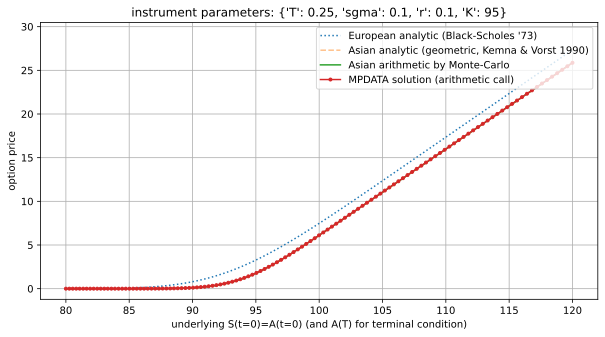

/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:395: RuntimeWarning: divide by zero encountered in divide
  abs(arithmetic_by_mc - history[frame_index][:, 0]) / arithmetic_by_mc,
/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:404: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100)


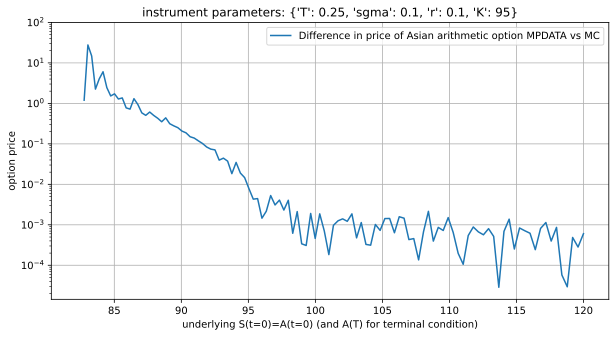

True price: 6.132
Numeric price: 6.117620067942513
MC price: 6.1208107318861265


In [5]:
params = {
        'T': 0.25,
        'K': 95,
        'r': 0.1,
        'sgma': 0.1,
        'spot': 100,
        'true_price': 6.132,
        'S_max': 120,
        'S_min': 80
    }
run_numeric_and_mc(params, nx=121, ny=500, nt=1500)

self.l2=6.737324795840403
CFL 0.33739169305000277
courant_x=0.004725026383336177, courant_y=0.3326666666666666
x_dim_advector.shape=(122, 500), self.a_dim_advector.shape=(121, 501)


IntProgress(value=0, max=1500)

MPDATA elapsed time: 17.602856159210205
Numeric price: 6.117620067954955


121it [06:24,  3.17s/it]


MC elapsed time: 384.0525276660919


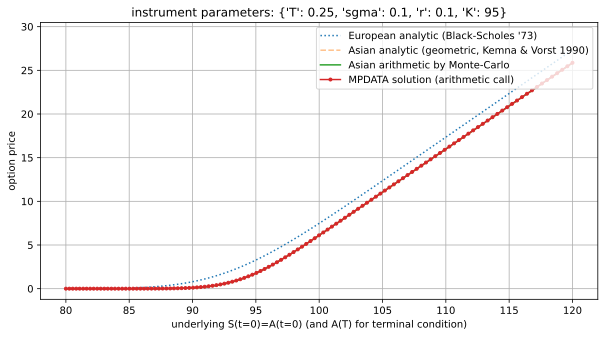

C:\Users\Pawel\PycharmProjects\PyMPDATA\examples\PyMPDATA_examples\Magnuszewski_et_al_2025\asian_option.py:404: RuntimeWarning: divide by zero encountered in divide
  abs(arithmetic_by_mc - history[frame_index][:, 0]) / arithmetic_by_mc,
C:\Users\Pawel\PycharmProjects\PyMPDATA\examples\PyMPDATA_examples\Magnuszewski_et_al_2025\asian_option.py:413: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100)


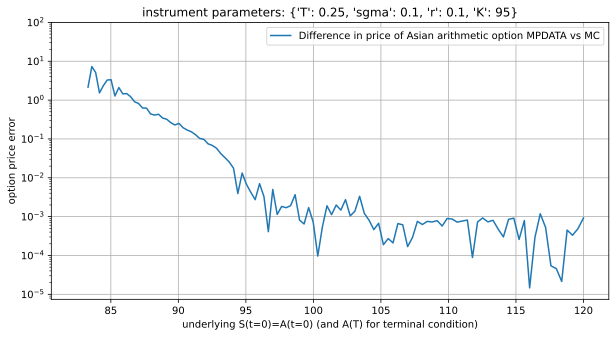

True price: 6.132
Numeric price: 6.117620067954955
MC price: 6.121811548784314


In [4]:
params = {
        'T': 0.25,
        'K': 95,
        'r': 0.1,
        'sgma': 0.1,
        'spot': 100,
        'true_price': 6.132,
        'S_max': 120,
        'S_min': 80
    }
run_numeric_and_mc(params, nx=121, ny=500, nt=1500)

self.l2=np.float64(9.66975515497494)
CFL 0.3366106969535836
courant_x=np.float64(0.003944030286916974), courant_y=np.float64(0.3326666666666666)
x_dim_advector.shape=(102, 500), self.a_dim_advector.shape=(101, 501)


IntProgress(value=0, max=1500)

MPDATA elapsed time: 65.01133799552917
Numeric price: 1.873875070498296


101it [03:25,  2.04s/it]

MC elapsed time: 205.91771578788757


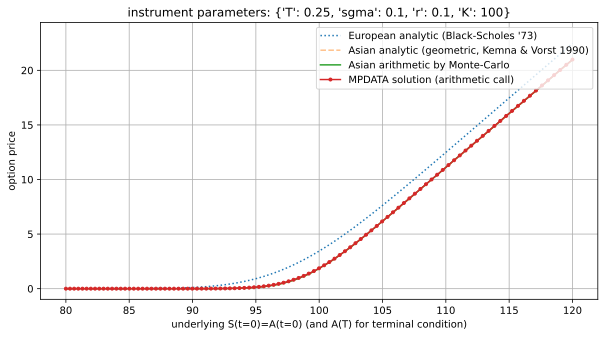

/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:395: RuntimeWarning: divide by zero encountered in divide
  abs(arithmetic_by_mc - history[frame_index][:, 0]) / arithmetic_by_mc,
/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:404: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100)


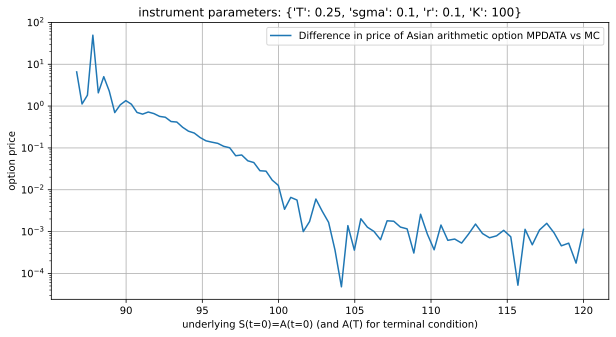

True price: 1.869
Numeric price: 1.873875070498296
MC price: 1.8510434244370215


In [37]:
params = {
        'T': 0.25,
        'K': 100,
        'r': 0.1,
        'sgma': 0.1,
        'spot': 100,
        'true_price': 1.869,
        'S_max': 120,
        'S_min': 80
    }
run_numeric_and_mc(params, nx=101, ny=500, nt=1500)

self.l2=np.float64(9.66975515497494)
CFL 0.3366106969535836
courant_x=np.float64(0.003944030286916974), courant_y=np.float64(0.3326666666666666)
x_dim_advector.shape=(102, 500), self.a_dim_advector.shape=(101, 501)


IntProgress(value=0, max=1500)

MPDATA elapsed time: 6.592661142349243
Numeric price: 0.17248245918828978


101it [03:21,  2.00s/it]

MC elapsed time: 201.8002269268036


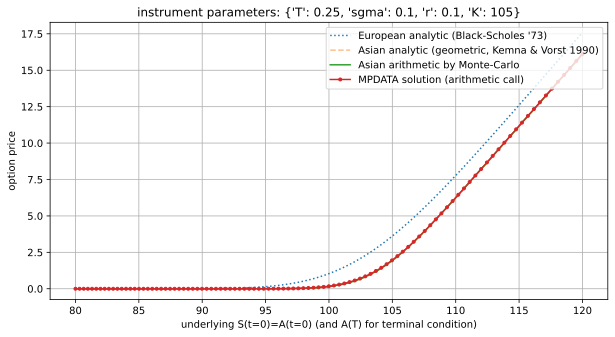

/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:395: RuntimeWarning: divide by zero encountered in divide
  abs(arithmetic_by_mc - history[frame_index][:, 0]) / arithmetic_by_mc,
/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:404: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100)


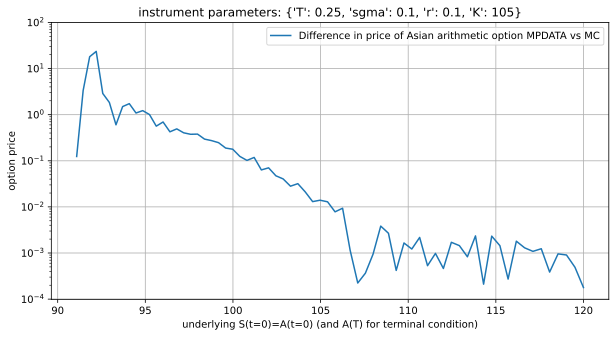

True price: 0.151
Numeric price: 0.17248245918828978
MC price: 0.14671374756013328


In [45]:
params = {
        'T': 0.25,
        'K': 105,
        'r': 0.1,
        'sgma': 0.1,
        'spot': 100,
        'true_price': 0.151,
        'S_max': 120,
        'S_min': 80
    }
run_numeric_and_mc(params, nx=101, ny=500, nt=1500)

### T = 0.5

self.l2=np.float64(4.83487757748747)
CFL 0.34055472724050057
courant_x=np.float64(0.007888060573833948), courant_y=np.float64(0.3326666666666666)
x_dim_advector.shape=(102, 500), self.a_dim_advector.shape=(101, 501)


IntProgress(value=0, max=1500)

MPDATA elapsed time: 36.11634802818298
Numeric price: 7.23805467438877


101it [04:12,  2.50s/it]

MC elapsed time: 252.5069715976715


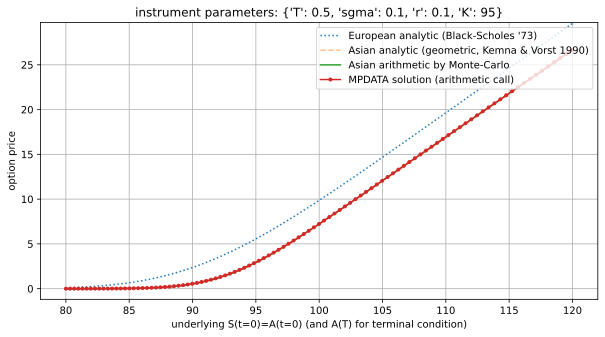

/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:404: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100)


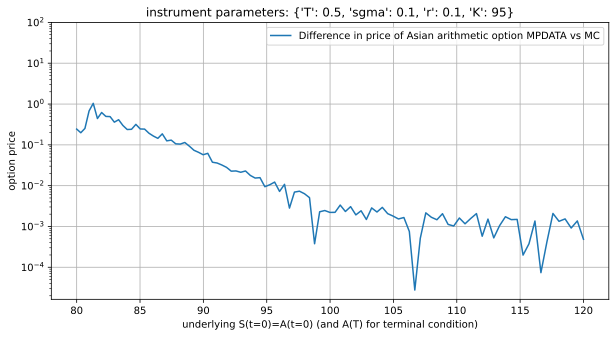

True price: 7.248
Numeric price: 7.23805467438877
MC price: 7.223247309952393


In [46]:
params = {
        'T': 0.5,
        'K': 95,
        'r': 0.1,
        'sgma': 0.1,
        'spot': 100,
        'true_price': 7.248,
        'S_max': 120,
        'S_min': 80
    }
run_numeric_and_mc(params, nx=101, ny=500, nt=1500)

self.l2=np.float64(9.783889340993785)
CFL 0.2715450722845763
courant_x=np.float64(0.0055450722845763415), courant_y=np.float64(0.26599999999999996)
x_dim_advector.shape=(72, 400), self.a_dim_advector.shape=(71, 401)


IntProgress(value=0, max=1500)

MPDATA elapsed time: 35.576953411102295
Numeric price: 3.1170989026076468


71it [02:51,  2.41s/it]

MC elapsed time: 171.40877079963684


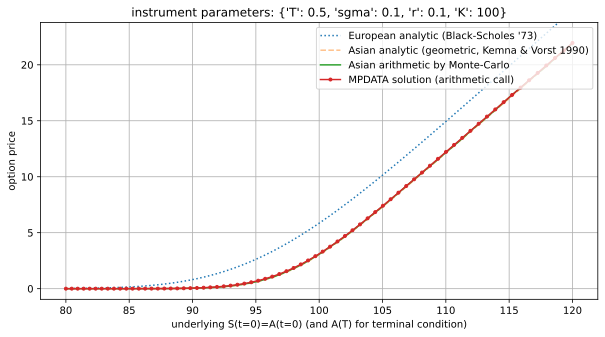

/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:395: RuntimeWarning: divide by zero encountered in divide
  abs(arithmetic_by_mc - history[frame_index][:, 0]) / arithmetic_by_mc,
/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:404: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100)


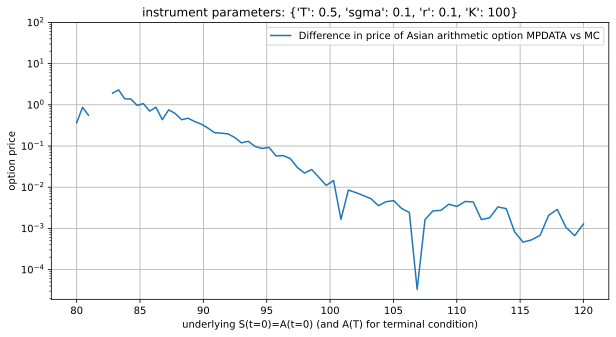

True price: 3.1
Numeric price: 3.1170989026076468
MC price: 3.0771666777085724


In [50]:
params = {
        'T': 0.5,
        'K': 100,
        'r': 0.1,
        'sgma': 0.1,
        'spot': 100,
        'true_price': 3.1,
        'S_max': 120,
        'S_min': 80
    }
run_numeric_and_mc(params, nx=71, ny=400, nt=1500)

self.l2=np.float64(6.44650343664996)
CFL 0.20541604543037542
courant_x=np.float64(0.005916045430375462), courant_y=np.float64(0.19949999999999996)
x_dim_advector.shape=(102, 400), self.a_dim_advector.shape=(101, 401)


IntProgress(value=0, max=2000)

MPDATA elapsed time: 51.17937707901001
Numeric price: 0.755516576533361


101it [03:25,  2.03s/it]

MC elapsed time: 205.32445168495178


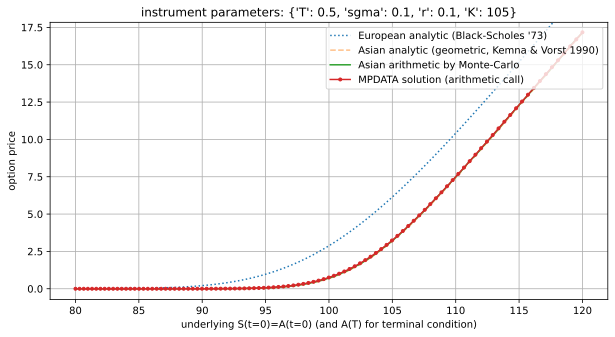

/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:395: RuntimeWarning: divide by zero encountered in divide
  abs(arithmetic_by_mc - history[frame_index][:, 0]) / arithmetic_by_mc,
/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:404: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100)


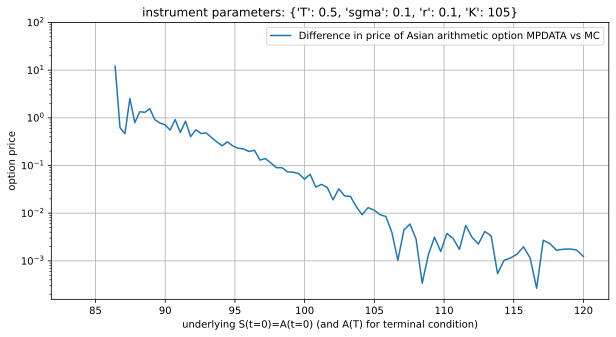

True price: 0.727
Numeric price: 0.755516576533361
MC price: 0.7181102171339728


In [7]:
params = {
        'T': 0.5,
        'K': 105,
        'r': 0.1,
        'sgma': 0.1,
        'spot': 100,
        'true_price': 0.727,
        'S_max': 120,
        'S_min': 80
    }
run_numeric_and_mc(params, nx=101, ny=400, nt=2000)

### T = 1

self.l2=np.float64(47.0986191469661)
CFL 0.20236853178346584
courant_x=np.float64(0.0027685317834659213), courant_y=np.float64(0.19959999999999992)
x_dim_advector.shape=(102, 500), self.a_dim_advector.shape=(101, 501)


IntProgress(value=0, max=2500)

MPDATA elapsed time: 40.146838903427124
Numeric price: 9.32109221064491


101it [03:22,  2.00s/it]

MC elapsed time: 202.10721015930176


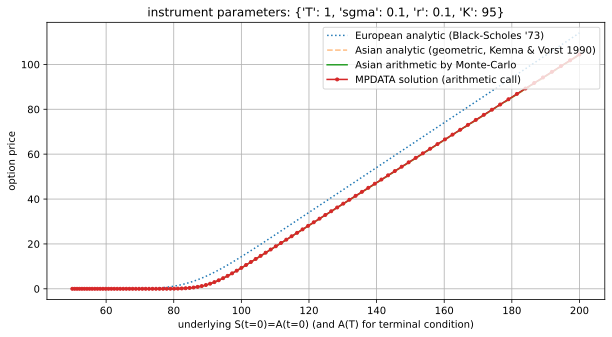

/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:395: RuntimeWarning: divide by zero encountered in divide
  abs(arithmetic_by_mc - history[frame_index][:, 0]) / arithmetic_by_mc,
/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:404: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100)


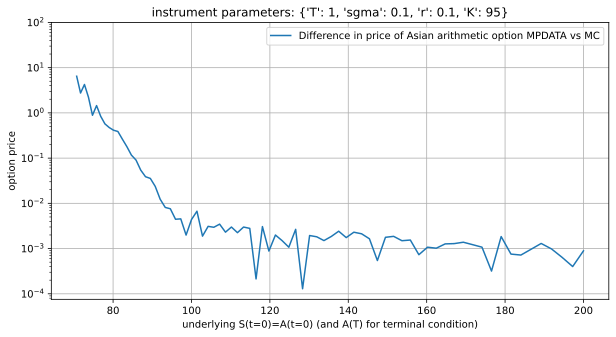

True price: 9.313
Numeric price: 9.32109221064491
MC price: 9.280451262059675


In [63]:
params = {
        'T': 1,
        'K': 95,
        'r': 0.1,
        'sgma': 0.1,
        'spot': 100,
        'true_price': 9.313,
    }
run_numeric_and_mc(params, nx=101, ny=500, nt=2500)

self.l2=np.float64(47.0986191469661)
CFL 0.20236853178346584
courant_x=np.float64(0.0027685317834659213), courant_y=np.float64(0.19959999999999992)
x_dim_advector.shape=(102, 500), self.a_dim_advector.shape=(101, 501)


IntProgress(value=0, max=2500)

MPDATA elapsed time: 40.21532130241394
Numeric price: 5.291606873926925


101it [03:22,  2.01s/it]

MC elapsed time: 202.9929702281952


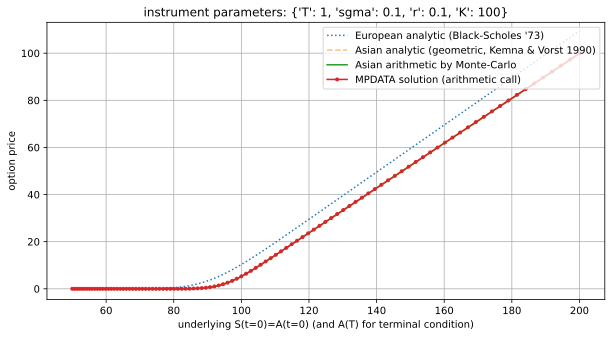

/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:395: RuntimeWarning: divide by zero encountered in divide
  abs(arithmetic_by_mc - history[frame_index][:, 0]) / arithmetic_by_mc,
/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:404: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100)


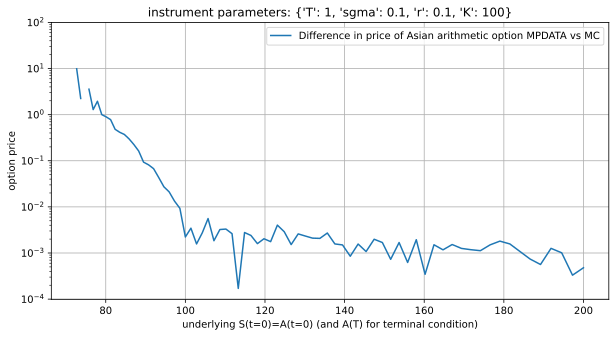

True price: 5.279
Numeric price: 5.291606873926925
MC price: 5.279868482000612


In [64]:
params = {
        'T': 1,
        'K': 100,
        'r': 0.1,
        'sgma': 0.1,
        'spot': 100,
        'true_price': 5.279,
    }
run_numeric_and_mc(params, nx=101, ny=500, nt=2500)

self.l2=np.float64(19.716959635506356)
CFL 0.20357276348987344
courant_x=np.float64(0.0039060968232068694), courant_y=np.float64(0.19966666666666658)
x_dim_advector.shape=(172, 600), self.a_dim_advector.shape=(171, 601)


IntProgress(value=0, max=3000)

MPDATA elapsed time: 42.432754039764404
Numeric price: 2.329833876655385


171it [07:08,  2.50s/it]

MC elapsed time: 428.2790036201477


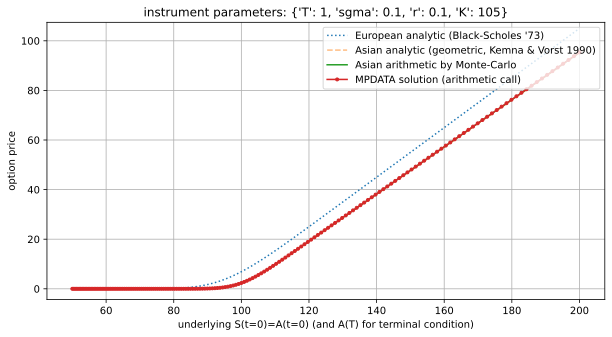

/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:395: RuntimeWarning: divide by zero encountered in divide
  abs(arithmetic_by_mc - history[frame_index][:, 0]) / arithmetic_by_mc,
/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:404: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100)


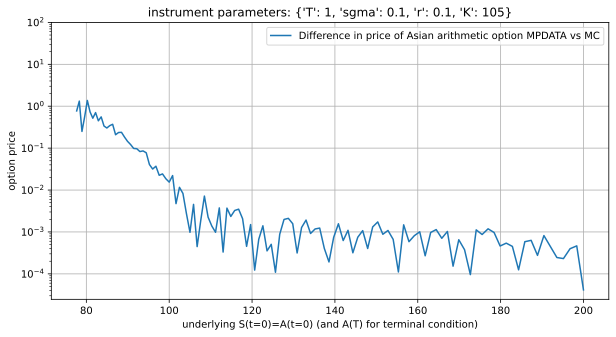

True price: 2.313
Numeric price: 2.329833876655385
MC price: 2.294358605447854


In [73]:
params = {
        'T': 1,
        'K': 105,
        'r': 0.1,
        'sgma': 0.1,
        'spot': 100,
        'true_price': 2.313,
    }
run_numeric_and_mc(params, nx=171, ny=600, nt=3000)

## sigma = 0.2

### T = 0.25

self.l2=np.float64(56.51834297635932)
CFL 0.16681904066376588
courant_x=np.float64(0.0004857073304326177), courant_y=np.float64(0.16633333333333325)
x_dim_advector.shape=(102, 500), self.a_dim_advector.shape=(101, 501)


IntProgress(value=0, max=3000)

MPDATA elapsed time: 44.36493515968323
Numeric price: 6.479734092585453


101it [04:14,  2.52s/it]

MC elapsed time: 254.65015649795532


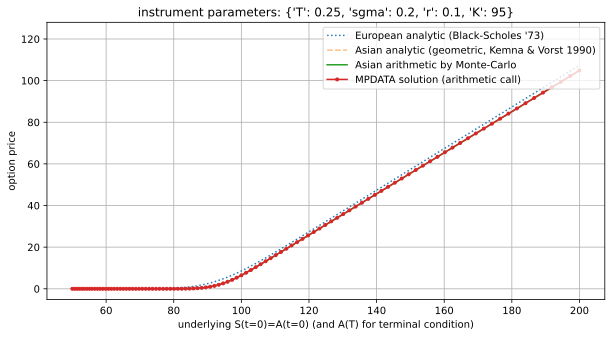

/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:395: RuntimeWarning: divide by zero encountered in divide
  abs(arithmetic_by_mc - history[frame_index][:, 0]) / arithmetic_by_mc,
/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:404: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100)


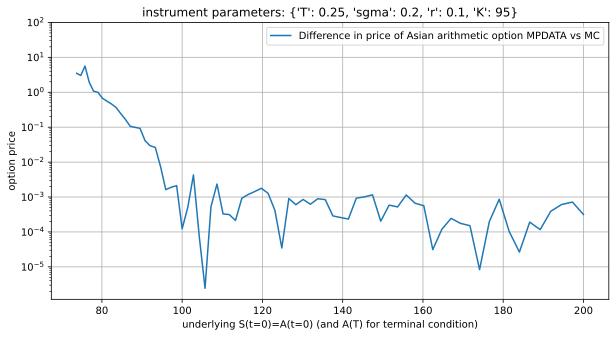

True price: 6.5
Numeric price: 6.479734092585453
MC price: 6.480534273237569


In [76]:
params = {
        'T': 0.25,
        'K': 95,
        'r': 0.1,
        'sgma': 0.2,
        'spot': 100,
        'true_price': 6.5,
    }
run_numeric_and_mc(params, nx=101, ny=500, nt=3000)

self.l2=np.float64(56.51834297635932)
CFL 0.16681904066376588
courant_x=np.float64(0.0004857073304326177), courant_y=np.float64(0.16633333333333325)
x_dim_advector.shape=(102, 500), self.a_dim_advector.shape=(101, 501)


IntProgress(value=0, max=3000)

MPDATA elapsed time: 41.78067398071289
Numeric price: 2.9615616957809614


101it [03:22,  2.00s/it]

MC elapsed time: 202.21847438812256


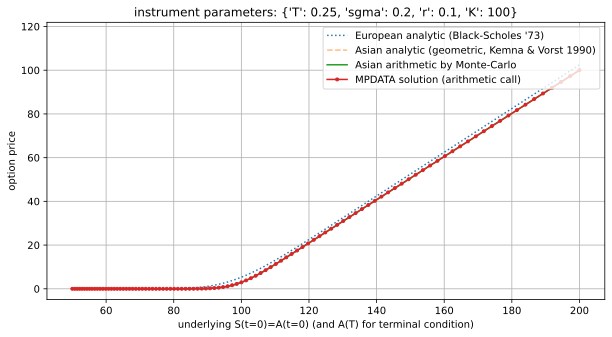

/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:395: RuntimeWarning: divide by zero encountered in divide
  abs(arithmetic_by_mc - history[frame_index][:, 0]) / arithmetic_by_mc,
/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:404: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100)


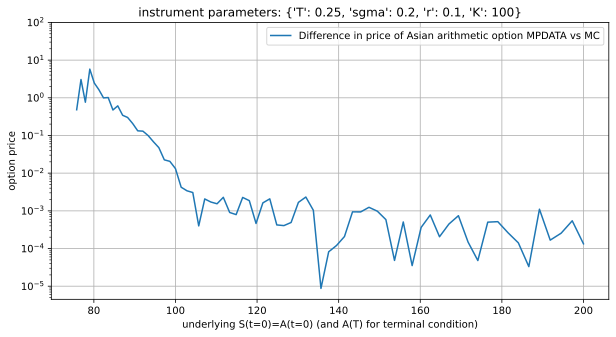

True price: 2.96
Numeric price: 2.9615616957809614
MC price: 2.9230179830439713


In [77]:
params = {
        'T': 0.25,
        'K': 100,
        'r': 0.1,
        'sgma': 0.2,
        'spot': 100,
        'true_price': 2.960,
    }
run_numeric_and_mc(params, nx=101, ny=500, nt=3000)

self.l2=np.float64(25.285891702199095)
CFL 0.2670594898372473
courant_x=np.float64(0.0007261565039141117), courant_y=np.float64(0.2663333333333332)
x_dim_advector.shape=(152, 800), self.a_dim_advector.shape=(151, 801)


IntProgress(value=0, max=3000)

MPDATA elapsed time: 67.22992396354675
Numeric price: 0.9735837467209867


151it [05:08,  2.04s/it]

MC elapsed time: 308.73529076576233


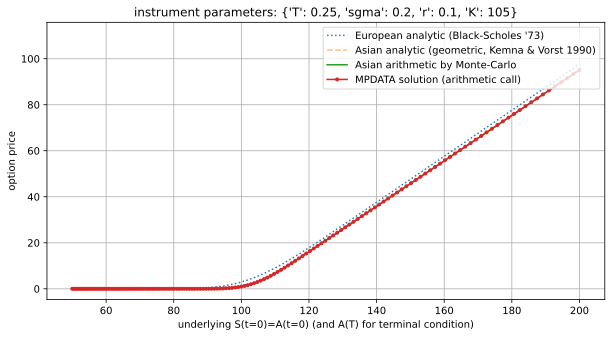

/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:395: RuntimeWarning: divide by zero encountered in divide
  abs(arithmetic_by_mc - history[frame_index][:, 0]) / arithmetic_by_mc,
/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:404: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100)


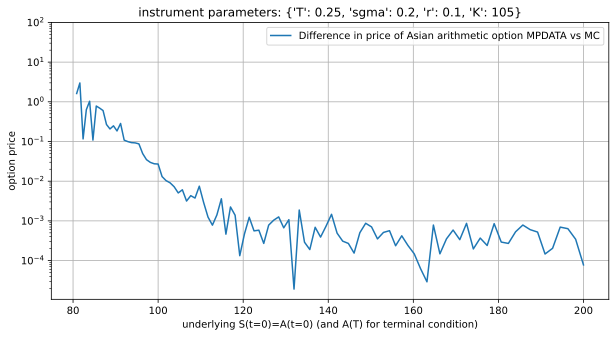

True price: 0.966
Numeric price: 0.9735837467209867
MC price: 0.9479796324019648


In [23]:
params = {
        'T': 0.25,
        'K': 105,
        'r': 0.1,
        'sgma': 0.2,
        'spot': 100,
        'true_price': 0.966,
    }
run_numeric_and_mc(params, nx=151, ny=800, nt=3000)

### T = 0.5

self.l2=np.float64(28.25917148817966)
CFL 0.10063808132753185
courant_x=np.float64(0.0009714146608652355), courant_y=np.float64(0.09966666666666661)
x_dim_advector.shape=(102, 300), self.a_dim_advector.shape=(101, 301)


IntProgress(value=0, max=3000)

MPDATA elapsed time: 43.361796855926514
Numeric price: 7.907266869619778


101it [03:28,  2.07s/it]

MC elapsed time: 208.6245617866516


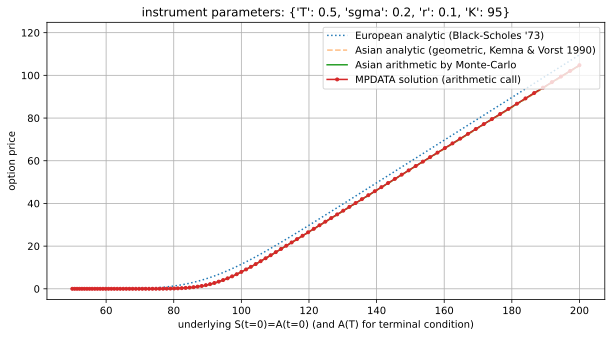

/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:395: RuntimeWarning: divide by zero encountered in divide
  abs(arithmetic_by_mc - history[frame_index][:, 0]) / arithmetic_by_mc,
/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:404: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100)


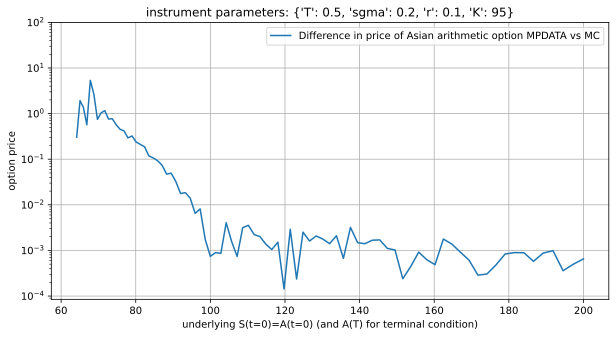

True price: 7.793
Numeric price: 7.907266869619778
MC price: 7.901410364533869


In [25]:
params = {
        'T': 0.5,
        'K': 95,
        'r': 0.1,
        'sgma': 0.2,
        'spot': 100,
        'true_price': 7.793,
    }
run_numeric_and_mc(params, nx=101, ny=300, nt=3000)

self.l2=np.float64(28.25917148817966)
CFL 0.10063808132753185
courant_x=np.float64(0.0009714146608652355), courant_y=np.float64(0.09966666666666661)
x_dim_advector.shape=(102, 300), self.a_dim_advector.shape=(101, 301)


IntProgress(value=0, max=3000)

MPDATA elapsed time: 64.4211094379425
Numeric price: 4.548534262410401


101it [03:28,  2.06s/it]

MC elapsed time: 208.44248747825623


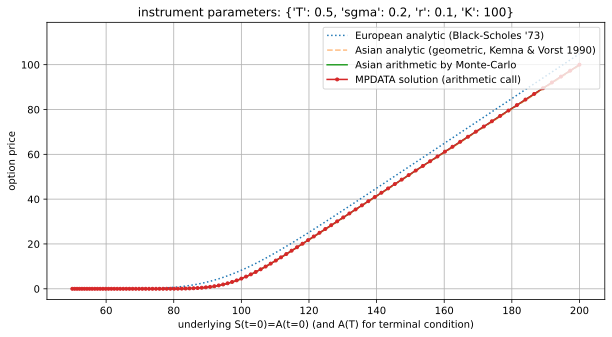

/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:395: RuntimeWarning: divide by zero encountered in divide
  abs(arithmetic_by_mc - history[frame_index][:, 0]) / arithmetic_by_mc,
/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:404: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100)


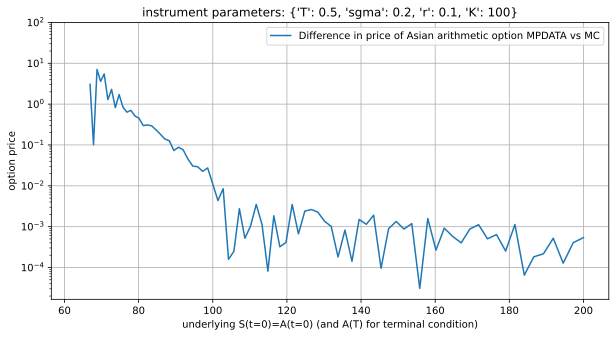

True price: 4.548
Numeric price: 4.548534262410401
MC price: 4.498795084403486


In [26]:
params = {
        'T': 0.5,
        'K': 100,
        'r': 0.1,
        'sgma': 0.2,
        'spot': 100,
        'true_price': 4.548,
    }
run_numeric_and_mc(params, nx=101, ny=300, nt=3000)

self.l2=np.float64(28.25917148817966)
CFL 0.13397141466086518
courant_x=np.float64(0.0009714146608652355), courant_y=np.float64(0.13299999999999995)
x_dim_advector.shape=(102, 400), self.a_dim_advector.shape=(101, 401)


IntProgress(value=0, max=3000)

MPDATA elapsed time: 19.9363956451416
Numeric price: 2.262972517589888


101it [03:22,  2.01s/it]

MC elapsed time: 202.7743284702301


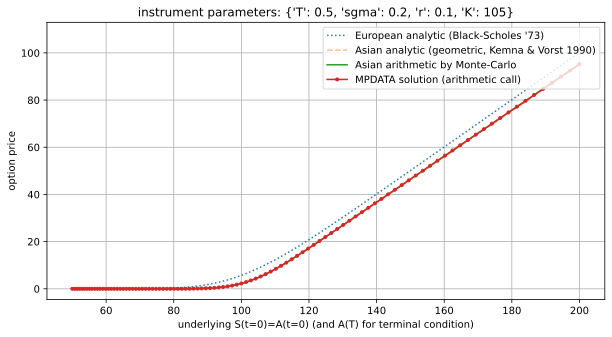

/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:395: RuntimeWarning: divide by zero encountered in divide
  abs(arithmetic_by_mc - history[frame_index][:, 0]) / arithmetic_by_mc,
/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:404: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100)


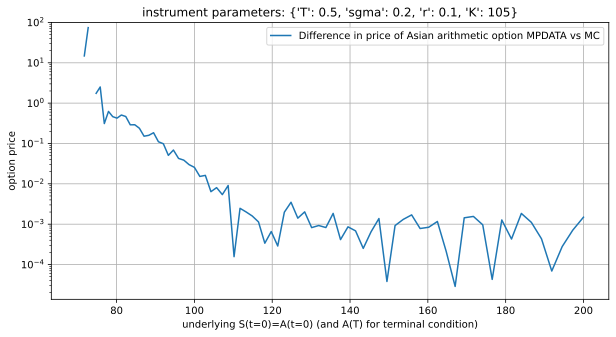

True price: 2.241
Numeric price: 2.262972517589888
MC price: 2.2065165941301417


In [30]:
params = {
        'T': 0.5,
        'K': 105,
        'r': 0.1,
        'sgma': 0.2,
        'spot': 100,
        'true_price': 2.241,
    }
run_numeric_and_mc(params, nx=101, ny=400, nt=3000)

### T = 1

self.l2=np.float64(14.12958574408983)
CFL 0.10160949598839708
courant_x=np.float64(0.001942829321730471), courant_y=np.float64(0.09966666666666661)
x_dim_advector.shape=(102, 300), self.a_dim_advector.shape=(101, 301)


IntProgress(value=0, max=3000)

MPDATA elapsed time: 11.284118890762329
Numeric price: 10.35798495255406


101it [03:22,  2.00s/it]

MC elapsed time: 202.11466360092163


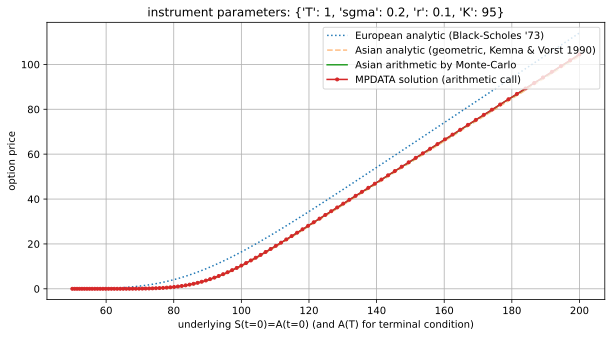

/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:395: RuntimeWarning: divide by zero encountered in divide
  abs(arithmetic_by_mc - history[frame_index][:, 0]) / arithmetic_by_mc,
/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:404: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100)


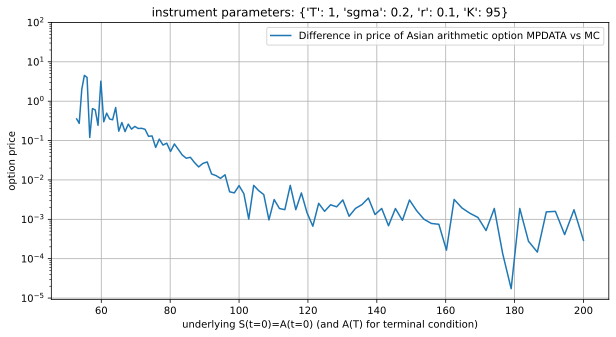

True price: 10.336
Numeric price: 10.35798495255406
MC price: 10.284173062381173


In [34]:
params = {
        'T': 1,
        'K': 95,
        'r': 0.1,
        'sgma': 0.2,
        'spot': 100,
        'true_price': 10.336,
    }
run_numeric_and_mc(params, nx=101, ny=300, nt=3000)

self.l2=np.float64(13.12623492707332)
CFL 0.051495660999475626
courant_x=np.float64(0.0017456609994756461), courant_y=np.float64(0.04974999999999998)
x_dim_advector.shape=(122, 200), self.a_dim_advector.shape=(121, 201)


IntProgress(value=0, max=4000)

MPDATA elapsed time: 60.90426731109619
Numeric price: 7.096975058351778


121it [04:08,  2.06s/it]

MC elapsed time: 248.98864316940308


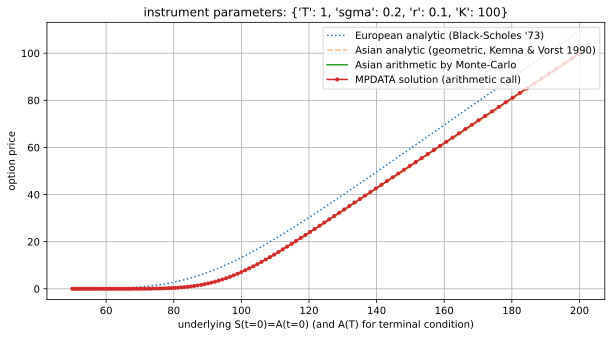

/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:395: RuntimeWarning: divide by zero encountered in divide
  abs(arithmetic_by_mc - history[frame_index][:, 0]) / arithmetic_by_mc,
/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:404: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100)


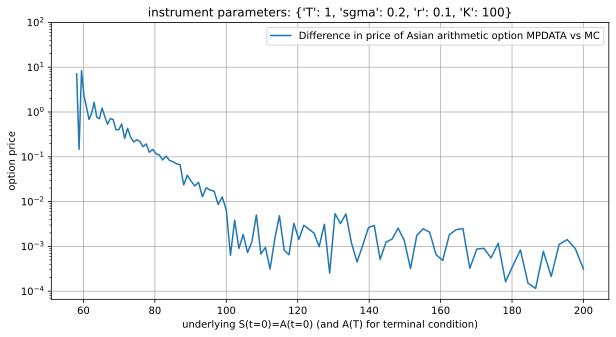

True price: 7.079
Numeric price: 7.096975058351778
MC price: 7.051676711641259


In [45]:
params = {
        'T': 1,
        'K': 100,
        'r': 0.1,
        'sgma': 0.2,
        'spot': 100,
        'true_price': 7.079,
    }
run_numeric_and_mc(params, nx=121, ny=200, nt=4000)

self.l2=np.float64(23.54930957348305)
CFL 0.05096569759303827
courant_x=np.float64(0.0011656975930382828), courant_y=np.float64(0.04979999999999998)
x_dim_advector.shape=(102, 250), self.a_dim_advector.shape=(101, 251)


IntProgress(value=0, max=5000)

MPDATA elapsed time: 76.43629837036133
Numeric price: 4.590857118265698


101it [03:28,  2.06s/it]

MC elapsed time: 208.16607403755188


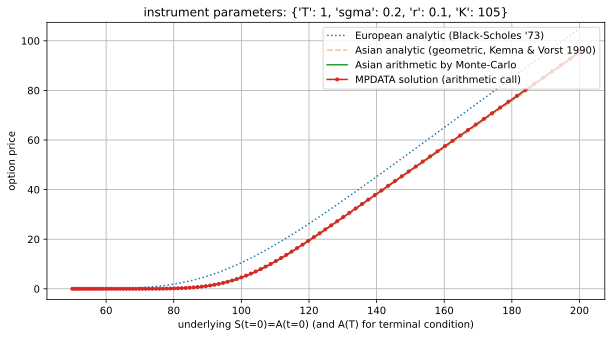

/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:395: RuntimeWarning: divide by zero encountered in divide
  abs(arithmetic_by_mc - history[frame_index][:, 0]) / arithmetic_by_mc,
/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:404: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100)


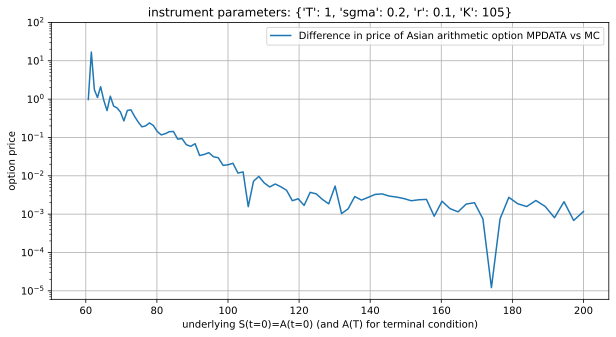

True price: 4.539
Numeric price: 4.590857118265698
MC price: 4.503736080266976


In [7]:
params = {
        'T': 1,
        'K': 105,
        'r': 0.1,
        'sgma': 0.2,
        'spot': 100,
        'true_price': 4.539,
    }
run_numeric_and_mc(params, nx=101, ny=250, nt=5000)

## sigma = 0.4

### T = 0.25

self.l2=np.float64(14.12958574408983)
CFL 0.09978809349927477
courant_x=np.float64(0.00012142683260815438), courant_y=np.float64(0.09966666666666661)
x_dim_advector.shape=(102, 300), self.a_dim_advector.shape=(101, 301)


IntProgress(value=0, max=3000)

MPDATA elapsed time: 54.102399826049805
Numeric price: 8.148219143453625


101it [04:27,  2.65s/it]

MC elapsed time: 267.14795303344727


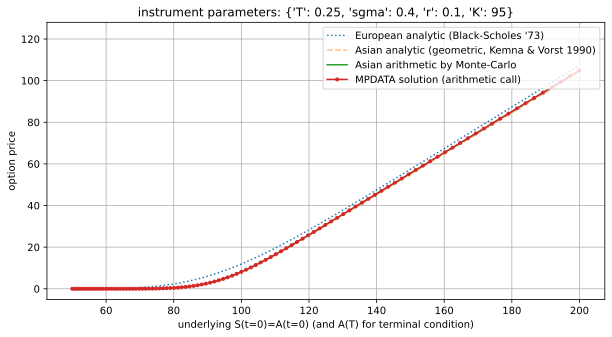

/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:395: RuntimeWarning: divide by zero encountered in divide
  abs(arithmetic_by_mc - history[frame_index][:, 0]) / arithmetic_by_mc,
/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:404: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100)


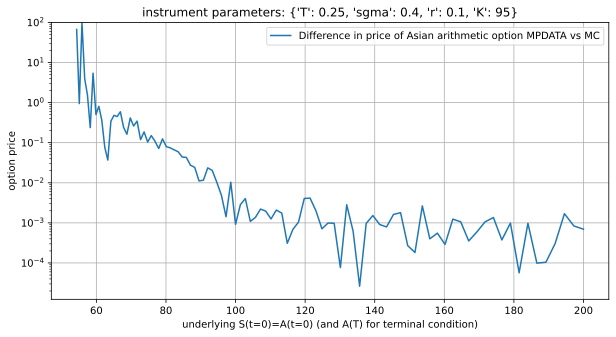

True price: 8.151
Numeric price: 8.148219143453625
MC price: 8.140743252725361


In [8]:
params = {
        'T': 0.25,
        'K': 95,
        'r': 0.1,
        'sgma': 0.4,
        'spot': 100,
        'true_price': 8.151,
    }
run_numeric_and_mc(params, nx=101, ny=300, nt=3000)

self.l2=np.float64(14.12958574408983)
CFL 0.06645476016594147
courant_x=np.float64(0.00012142683260815438), courant_y=np.float64(0.06633333333333331)
x_dim_advector.shape=(102, 200), self.a_dim_advector.shape=(101, 201)


IntProgress(value=0, max=3000)

MPDATA elapsed time: 73.67468810081482
Numeric price: 5.232699634724515


101it [03:28,  2.07s/it]

MC elapsed time: 208.96177792549133


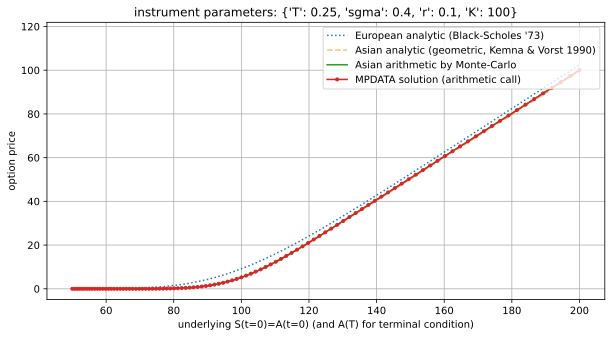

/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:395: RuntimeWarning: divide by zero encountered in divide
  abs(arithmetic_by_mc - history[frame_index][:, 0]) / arithmetic_by_mc,
/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:404: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100)


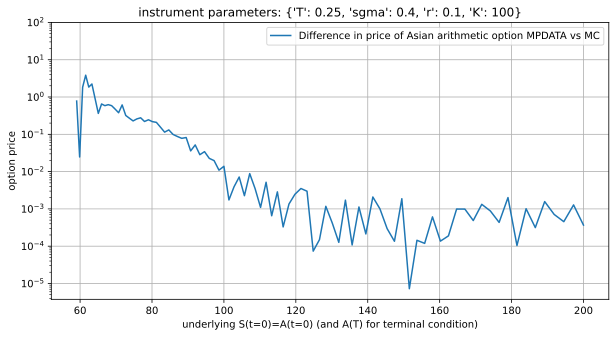

True price: 5.218
Numeric price: 5.232699634724515
MC price: 5.161130694728721


In [10]:
params = {
        'T': 0.25,
        'K': 100,
        'r': 0.1,
        'sgma': 0.4,
        'spot': 100,
        'true_price': 5.218,
    }
run_numeric_and_mc(params, nx=101, ny=200, nt=3000)

self.l2=np.float64(36.61431290338371)
CFL 0.039858429149155994
courant_x=np.float64(5.8429149156003e-05), courant_y=np.float64(0.03979999999999999)
x_dim_advector.shape=(82, 200), self.a_dim_advector.shape=(81, 201)


IntProgress(value=0, max=5000)

MPDATA elapsed time: 88.09815859794617
Numeric price: 3.156410250692144


81it [03:24,  2.52s/it]

MC elapsed time: 204.52555775642395


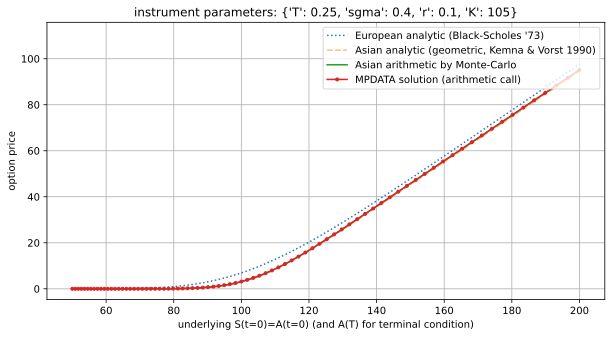

/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:395: RuntimeWarning: divide by zero encountered in divide
  abs(arithmetic_by_mc - history[frame_index][:, 0]) / arithmetic_by_mc,
/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:404: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100)


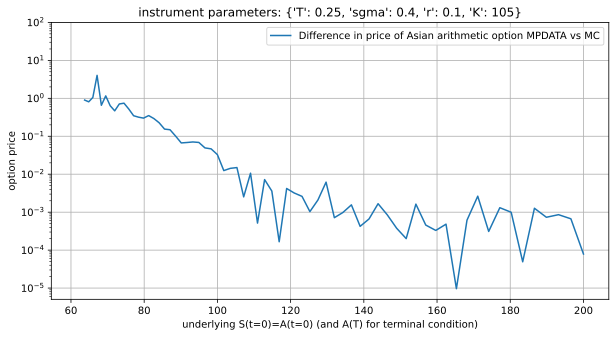

True price: 3.106
Numeric price: 3.156410250692144
MC price: 3.0561261961139525


In [19]:
params = {
        'T': 0.25,
        'K': 105,
        'r': 0.1,
        'sgma': 0.4,
        'spot': 100,
        'true_price': 3.106,
    }
run_numeric_and_mc(params, nx=81, ny=200, nt=5000)

### T = 0.5

self.l2=np.float64(18.307156451691856)
CFL 0.03991685829831199
courant_x=np.float64(0.000116858298312006), courant_y=np.float64(0.03979999999999999)
x_dim_advector.shape=(82, 200), self.a_dim_advector.shape=(81, 201)


IntProgress(value=0, max=5000)

MPDATA elapsed time: 124.03241348266602
Numeric price: 10.446123536926867


81it [03:36,  2.68s/it]

MC elapsed time: 216.9741814136505


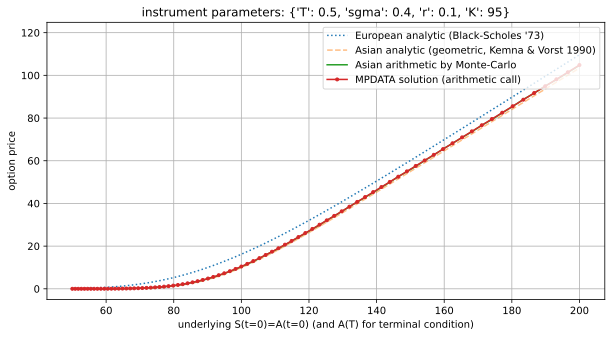

/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:404: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100)


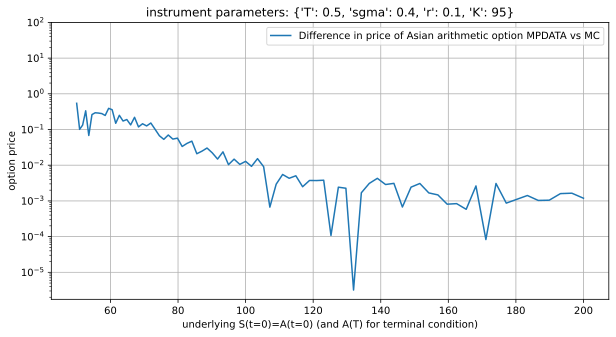

True price: 10.425
Numeric price: 10.446123536926867
MC price: 10.313906034050241


In [23]:
params = {
        'T': 0.5,
        'K': 95,
        'r': 0.1,
        'sgma': 0.4,
        'spot': 100,
        'true_price': 10.425,
    }
run_numeric_and_mc(params, nx=81, ny=200, nt=5000)

self.l2=np.float64(18.307156451691856)
CFL 0.03991685829831199
courant_x=np.float64(0.000116858298312006), courant_y=np.float64(0.03979999999999999)
x_dim_advector.shape=(82, 200), self.a_dim_advector.shape=(81, 201)


IntProgress(value=0, max=5000)

MPDATA elapsed time: 131.24387907981873
Numeric price: 7.68451177587822


81it [02:49,  2.10s/it]

MC elapsed time: 169.76302123069763


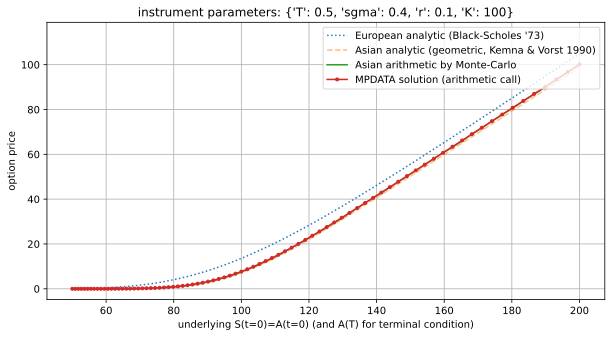

/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:404: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100)


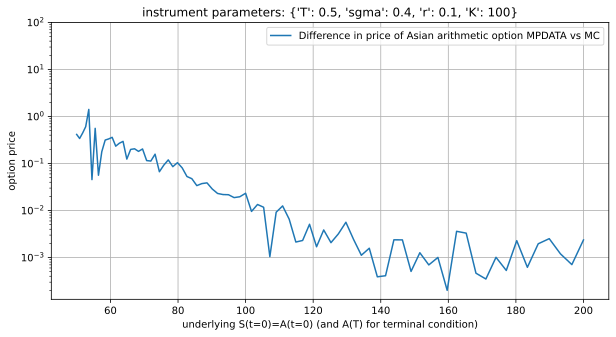

True price: 7.65
Numeric price: 7.68451177587822
MC price: 7.509663741280927


In [25]:
params = {
        'T': 0.5,
        'K': 100,
        'r': 0.1,
        'sgma': 0.4,
        'spot': 100,
        'true_price': 7.650,
    }
run_numeric_and_mc(params, nx=81, ny=200, nt=5000)

self.l2=np.float64(18.307156451691856)
CFL 0.02991685829831199
courant_x=np.float64(0.000116858298312006), courant_y=np.float64(0.029799999999999986)
x_dim_advector.shape=(82, 150), self.a_dim_advector.shape=(81, 151)


IntProgress(value=0, max=5000)

MPDATA elapsed time: 124.118656873703
Numeric price: 5.49905668963933


81it [02:53,  2.14s/it]

MC elapsed time: 173.67766666412354


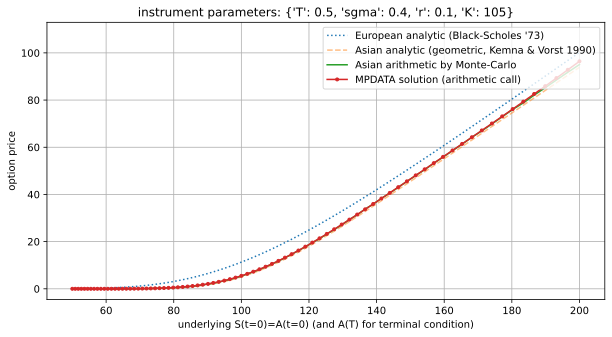

/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:404: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100)


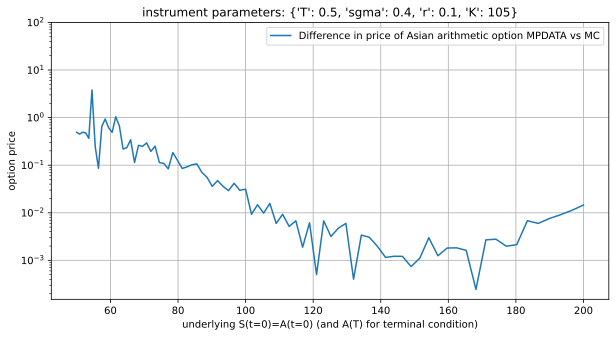

True price: 5.444
Numeric price: 5.49905668963933
MC price: 5.33228621554954


In [27]:
params = {
        'T': 0.5,
        'K': 105,
        'r': 0.1,
        'sgma': 0.4,
        'spot': 100,
        'true_price': 5.444,
    }
run_numeric_and_mc(params, nx=81, ny=150, nt=5000)

### T = 1

self.l2=np.float64(4.70986191469661)
CFL 0.025614280497824455
courant_x=np.float64(0.00036428049782446316), courant_y=np.float64(0.02524999999999999)
x_dim_advector.shape=(102, 102), self.a_dim_advector.shape=(101, 103)


IntProgress(value=0, max=4000)

MPDATA elapsed time: 13.946833848953247
Numeric price: 13.855097055660202


101it [03:25,  2.03s/it]

MC elapsed time: 205.22511911392212


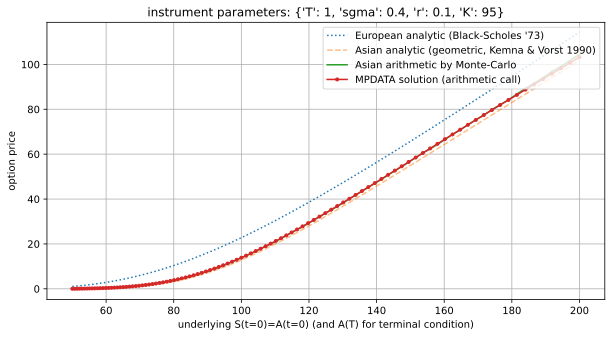

/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:404: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100)


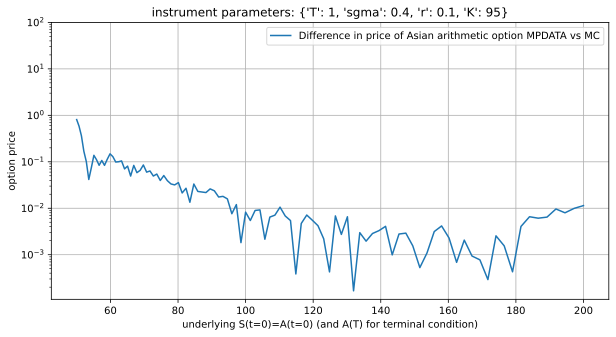

True price: 13.825
Numeric price: 13.855097055660202
MC price: 13.741926903990185


In [58]:
params = {
        'T': 1,
        'K': 95,
        'r': 0.1,
        'sgma': 0.4,
        'spot': 100,
        'true_price': 13.825,
    }
run_numeric_and_mc(params, nx=101, ny=102, nt=4000)

self.l2=np.float64(4.70986191469661)
CFL 0.025614280497824455
courant_x=np.float64(0.00036428049782446316), courant_y=np.float64(0.02524999999999999)
x_dim_advector.shape=(102, 102), self.a_dim_advector.shape=(101, 103)


IntProgress(value=0, max=4000)

MPDATA elapsed time: 14.22810673713684
Numeric price: 11.271253489580493


101it [03:25,  2.03s/it]

MC elapsed time: 205.29935455322266


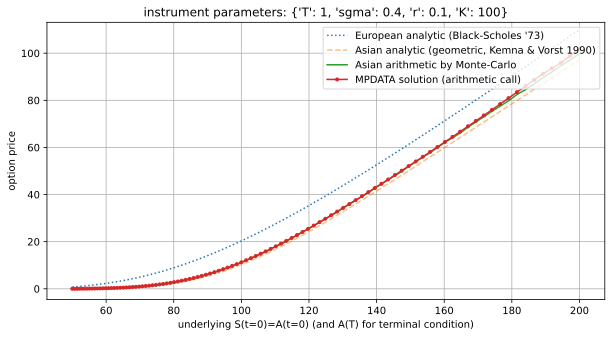

/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:404: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100)


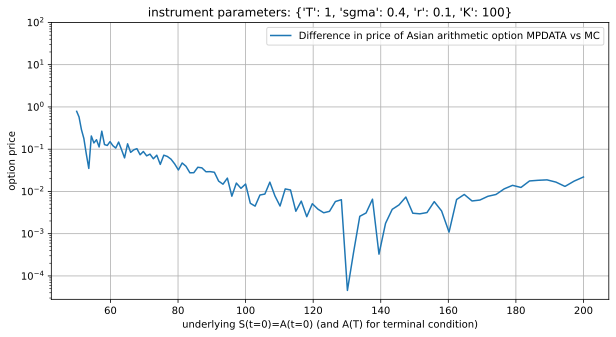

True price: 11.213
Numeric price: 11.271253489580493
MC price: 11.105145084505846


In [63]:
params = {
        'T': 1,
        'K': 100,
        'r': 0.1,
        'sgma': 0.4,
        'spot': 100,
        'true_price': 11.213,
    }
run_numeric_and_mc(params, nx=101, ny=102, nt=4000)

self.l2=np.float64(4.70986191469661)
CFL 0.025614280497824455
courant_x=np.float64(0.00036428049782446316), courant_y=np.float64(0.02524999999999999)
x_dim_advector.shape=(102, 102), self.a_dim_advector.shape=(101, 103)


IntProgress(value=0, max=4000)

MPDATA elapsed time: 43.496519804000854
Numeric price: 9.069009024996241


101it [03:24,  2.03s/it]

MC elapsed time: 204.53332710266113


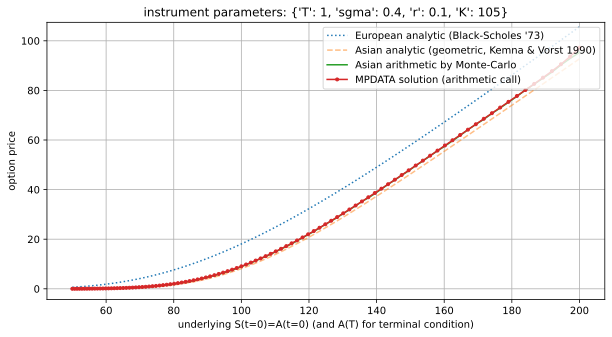

/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:404: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100)


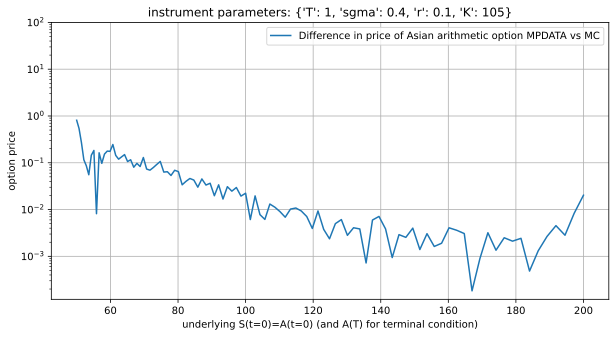

True price: 8.989
Numeric price: 9.069009024996241
MC price: 8.870991019686969


In [61]:
params = {
        'T': 1,
        'K': 105,
        'r': 0.1,
        'sgma': 0.4,
        'spot': 100,
        'true_price': 8.989,
    }
run_numeric_and_mc(params, nx=101, ny=102, nt=4000)

# Put

## sigma = 0.1

### T = 0.25

self.l2=np.float64(28.827180835092065)
CFL 0.2682842671480741
courant_x=np.float64(0.0022842671480741926), courant_y=np.float64(0.2659999999999999)
x_dim_advector.shape=(201, 400), self.a_dim_advector.shape=(200, 401)


IntProgress(value=0, max=1500)

MPDATA elapsed time: 6.664181470870972
Numeric price: 0.012777092496087496


200it [08:19,  2.50s/it]


MC elapsed time: 499.4820206165314


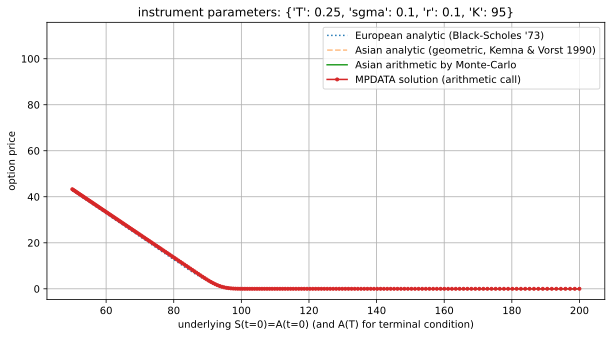

/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:413: RuntimeWarning: divide by zero encountered in divide
  abs(arithmetic_by_mc - history[frame_index][:, 0]) / arithmetic_by_mc,
/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:422: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100)


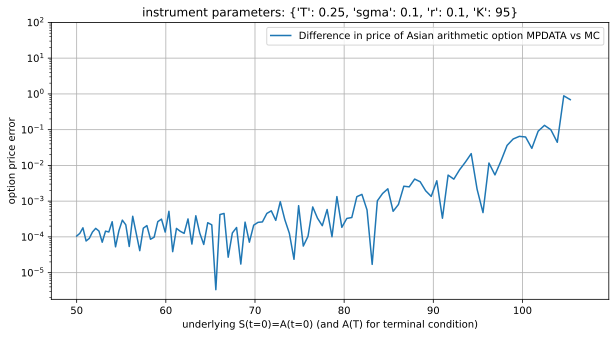

True price: 0.013
Numeric price: 0.012777092496087496
MC price: 0.01365262309322565


In [4]:
params = {
        'T': 0.25,
        'K': 95,
        'r': 0.1,
        'sgma': 0.1,
        'spot': 100,
        'true_price': 0.013,
    }
run_numeric_and_mc(params, nx=200, ny=400, nt=1500, variant='put')

self.l2=np.float64(28.827180835092065)
CFL 0.2682842671480741
courant_x=np.float64(0.0022842671480741926), courant_y=np.float64(0.2659999999999999)
x_dim_advector.shape=(201, 400), self.a_dim_advector.shape=(200, 401)


IntProgress(value=0, max=1500)

MPDATA elapsed time: 6.321263790130615
Numeric price: 0.6334633046164623


200it [06:47,  2.04s/it]

MC elapsed time: 407.8348774909973


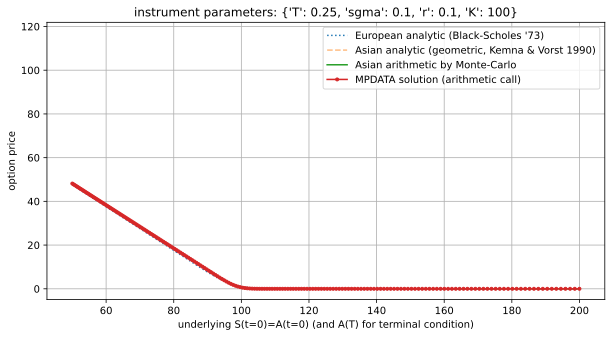

/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:413: RuntimeWarning: divide by zero encountered in divide
  abs(arithmetic_by_mc - history[frame_index][:, 0]) / arithmetic_by_mc,
/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:422: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100)


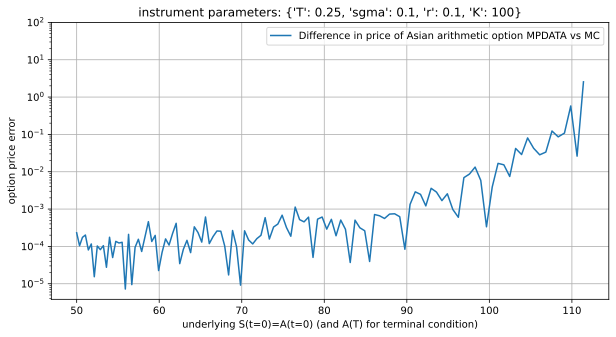

True price: 0.624
Numeric price: 0.6334633046164623
MC price: 0.6323299958269782


In [7]:
params = {
        'T': 0.25,
        'K': 100,
        'r': 0.1,
        'sgma': 0.1,
        'spot': 100,
        'true_price': 0.624,
    }
run_numeric_and_mc(params, nx=200, ny=400, nt=1500, variant='put')

self.l2=np.float64(28.827180835092065)
CFL 0.2682842671480741
courant_x=np.float64(0.0022842671480741926), courant_y=np.float64(0.2659999999999999)
x_dim_advector.shape=(201, 400), self.a_dim_advector.shape=(200, 401)


IntProgress(value=0, max=1500)

MPDATA elapsed time: 7.746179103851318
Numeric price: 3.7982460605446993


200it [06:43,  2.02s/it]

MC elapsed time: 403.66155552864075


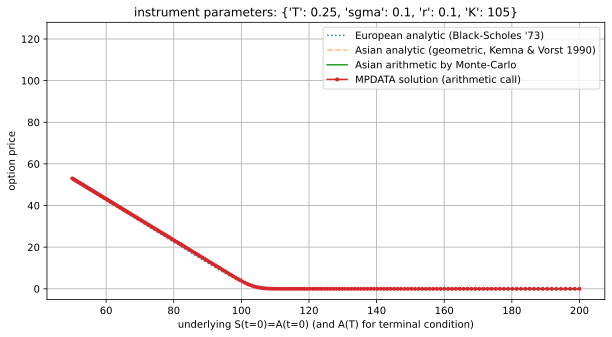

/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:413: RuntimeWarning: divide by zero encountered in divide
  abs(arithmetic_by_mc - history[frame_index][:, 0]) / arithmetic_by_mc,
/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:422: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100)


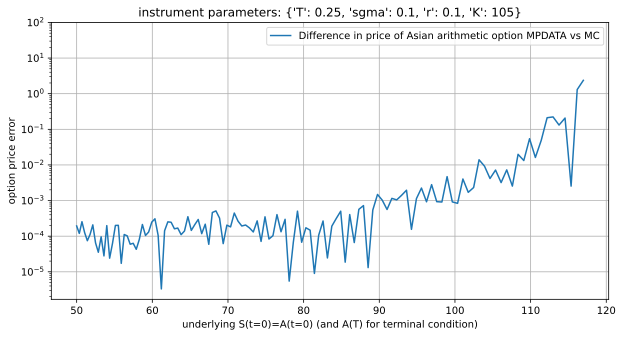

True price: 3.785
Numeric price: 3.7982460605446993
MC price: 3.7986762148465387


In [6]:
params = {
        'T': 0.25,
        'K': 105,
        'r': 0.1,
        'sgma': 0.1,
        'spot': 100,
        'true_price': 3.785,
    }
run_numeric_and_mc(params, nx=200, ny=400, nt=1500, variant='put')

self.l2=np.float64(9.609060278364021)
CFL 0.2058528014442225
courant_x=np.float64(0.006852801444222578), courant_y=np.float64(0.19899999999999993)
x_dim_advector.shape=(201, 200), self.a_dim_advector.shape=(200, 201)


IntProgress(value=0, max=1000)

MPDATA elapsed time: 3.602018356323242
Numeric price: 0.04714652063297036


200it [08:26,  2.53s/it]

MC elapsed time: 506.1392478942871


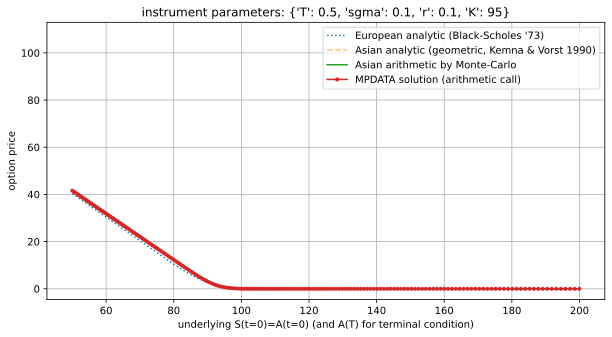

/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:413: RuntimeWarning: divide by zero encountered in divide
  abs(arithmetic_by_mc - history[frame_index][:, 0]) / arithmetic_by_mc,
/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:422: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100)


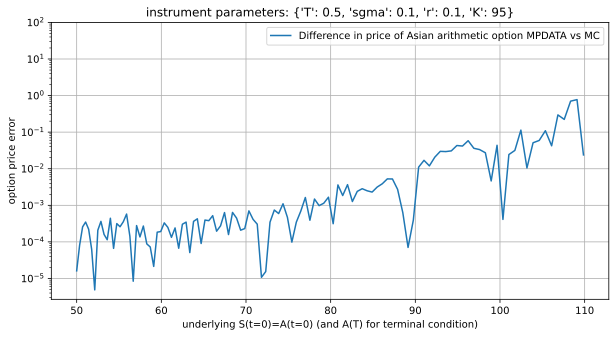

True price: 0.046
Numeric price: 0.04714652063297036
MC price: 0.045951004279038324


In [16]:
params = {
        'T': 0.5,
        'K': 95,
        'r': 0.1,
        'sgma': 0.1,
        'spot': 100,
        'true_price': 0.046,
    }
run_numeric_and_mc(params, nx=200, ny=200, nt=1000, variant='put')

self.l2=np.float64(9.609060278364021)
CFL 0.2058528014442225
courant_x=np.float64(0.006852801444222578), courant_y=np.float64(0.19899999999999993)
x_dim_advector.shape=(201, 200), self.a_dim_advector.shape=(200, 201)


IntProgress(value=0, max=1000)

MPDATA elapsed time: 3.191105604171753
Numeric price: 0.6755355343517594


200it [06:41,  2.01s/it]

MC elapsed time: 401.8144726753235


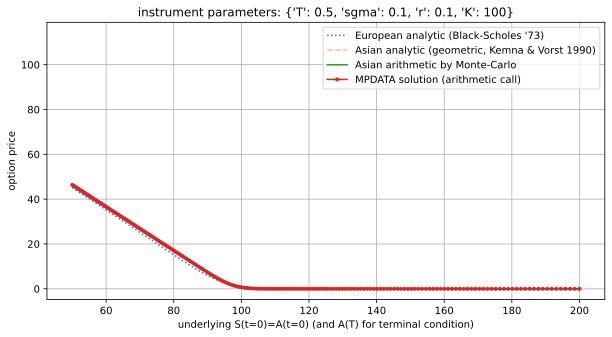

/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:413: RuntimeWarning: divide by zero encountered in divide
  abs(arithmetic_by_mc - history[frame_index][:, 0]) / arithmetic_by_mc,
/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:422: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100)


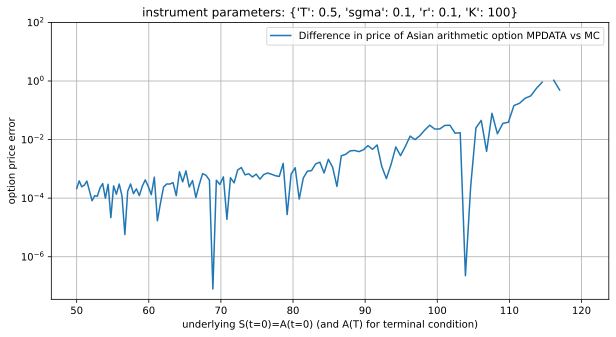

True price: 0.655
Numeric price: 0.6755355343517594
MC price: 0.6604116374657183


In [17]:
params = {
        'T': 0.5,
        'K': 100,
        'r': 0.1,
        'sgma': 0.1,
        'spot': 100,
        'true_price': 0.655,
    }
run_numeric_and_mc(params, nx=200, ny=200, nt=1000, variant='put')

self.l2=np.float64(9.609060278364021)
CFL 0.2058528014442225
courant_x=np.float64(0.006852801444222578), courant_y=np.float64(0.19899999999999993)
x_dim_advector.shape=(201, 200), self.a_dim_advector.shape=(200, 201)


IntProgress(value=0, max=1000)

MPDATA elapsed time: 2.9280269145965576
Numeric price: 3.0719973370261897


200it [06:41,  2.01s/it]

MC elapsed time: 401.4987404346466


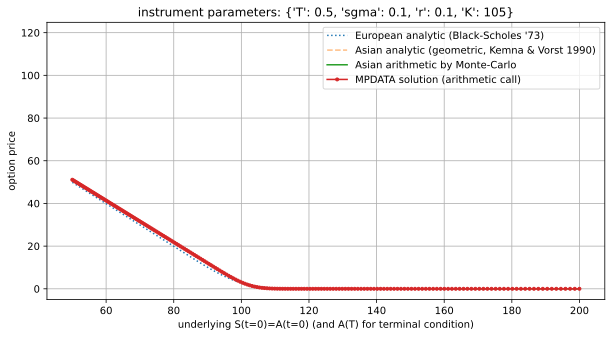

/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:413: RuntimeWarning: divide by zero encountered in divide
  abs(arithmetic_by_mc - history[frame_index][:, 0]) / arithmetic_by_mc,
/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:422: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100)


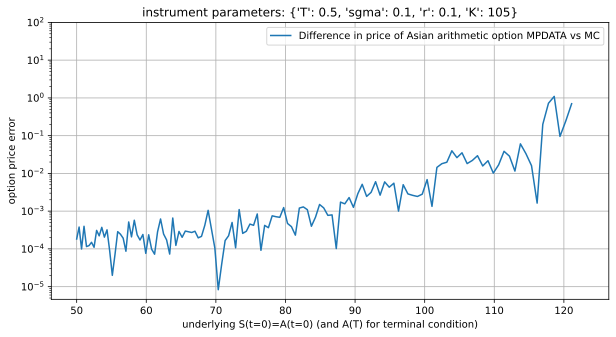

True price: 3.039
Numeric price: 3.0719973370261897
MC price: 3.0577108775345474


In [18]:
params = {
        'T': 0.5,
        'K': 105,
        'r': 0.1,
        'sgma': 0.1,
        'spot': 100,
        'true_price': 3.039,
    }
run_numeric_and_mc(params, nx=200, ny=200, nt=1000, variant='put')

self.l2=np.float64(4.8045301391820106)
CFL 0.2127056028884451
courant_x=np.float64(0.013705602888445157), courant_y=np.float64(0.19899999999999993)
x_dim_advector.shape=(201, 200), self.a_dim_advector.shape=(200, 201)


IntProgress(value=0, max=1000)

MPDATA elapsed time: 4.371012449264526
Numeric price: 0.08053257256841188


200it [06:45,  2.03s/it]

MC elapsed time: 405.68738079071045


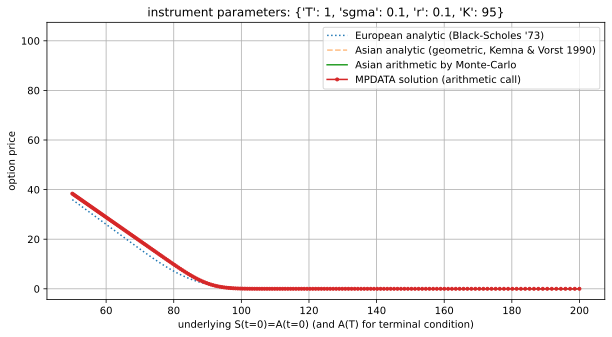

/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:413: RuntimeWarning: divide by zero encountered in divide
  abs(arithmetic_by_mc - history[frame_index][:, 0]) / arithmetic_by_mc,
/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:422: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100)


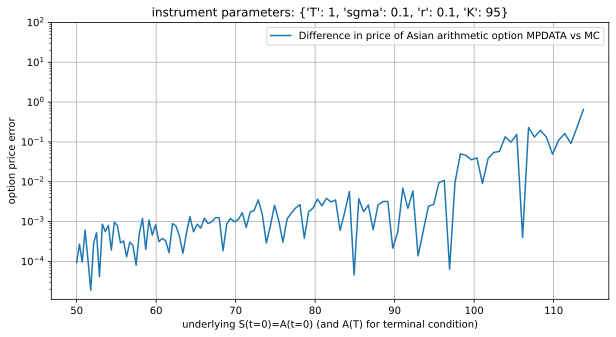

True price: 0.084
Numeric price: 0.08053257256841188
MC price: 0.08365062591258933


In [19]:
params = {
        'T': 1,
        'K': 95,
        'r': 0.1,
        'sgma': 0.1,
        'spot': 100,
        'true_price': 0.084,
    }
run_numeric_and_mc(params, nx=200, ny=200, nt=1000, variant='put')

self.l2=np.float64(4.8045301391820106)
CFL 0.2127056028884451
courant_x=np.float64(0.013705602888445157), courant_y=np.float64(0.19899999999999993)
x_dim_advector.shape=(201, 200), self.a_dim_advector.shape=(200, 201)


IntProgress(value=0, max=1000)

MPDATA elapsed time: 3.9839422702789307
Numeric price: 0.5750143496096317


200it [06:48,  2.04s/it]

MC elapsed time: 408.5220260620117


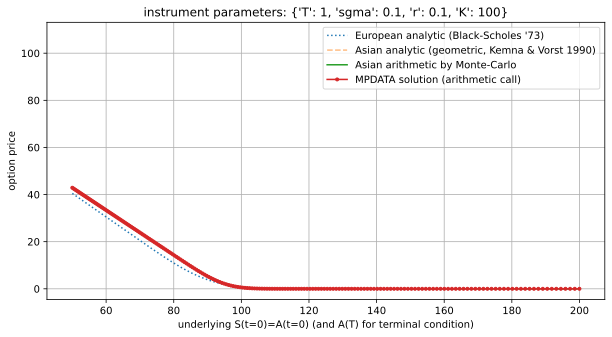

/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:413: RuntimeWarning: divide by zero encountered in divide
  abs(arithmetic_by_mc - history[frame_index][:, 0]) / arithmetic_by_mc,
/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:422: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100)


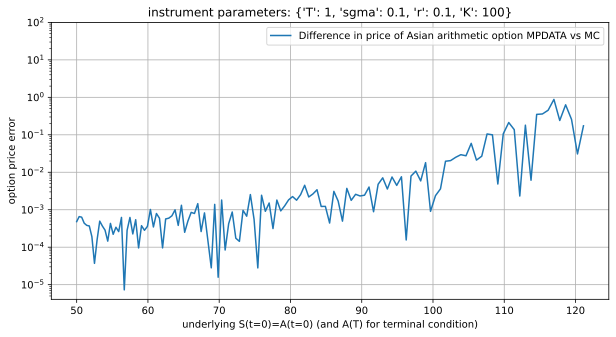

True price: 0.57
Numeric price: 0.5750143496096317
MC price: 0.5753349569020421


In [20]:
params = {
        'T': 1,
        'K': 100,
        'r': 0.1,
        'sgma': 0.1,
        'spot': 100,
        'true_price': 0.57,
    }
run_numeric_and_mc(params, nx=200, ny=200, nt=1000, variant='put')

self.l2=np.float64(4.8045301391820106)
CFL 0.2127056028884451
courant_x=np.float64(0.013705602888445157), courant_y=np.float64(0.19899999999999993)
x_dim_advector.shape=(201, 200), self.a_dim_advector.shape=(200, 201)


IntProgress(value=0, max=1000)

MPDATA elapsed time: 4.279627084732056
Numeric price: 2.1450968025220645


200it [06:49,  2.05s/it]

MC elapsed time: 409.1793339252472


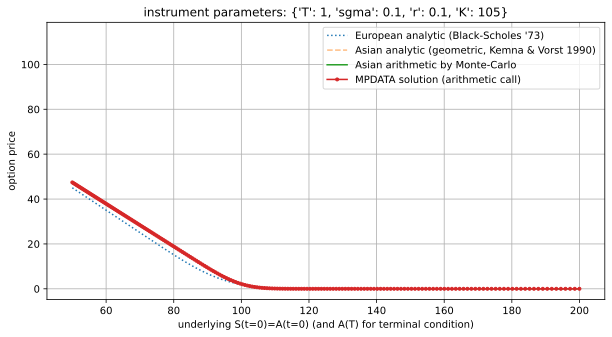

/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:413: RuntimeWarning: divide by zero encountered in divide
  abs(arithmetic_by_mc - history[frame_index][:, 0]) / arithmetic_by_mc,
/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:422: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100)


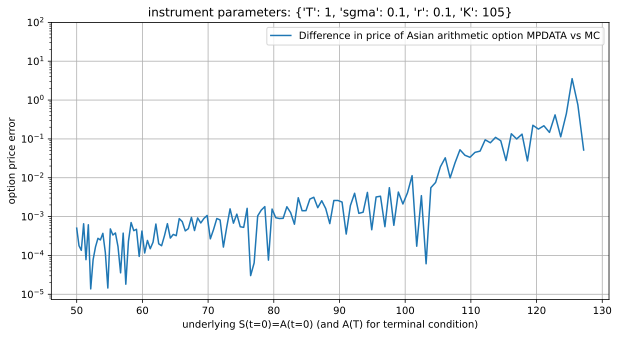

True price: 2.137
Numeric price: 2.1450968025220645
MC price: 2.1386287843157326


In [21]:
params = {
        'T': 1,
        'K': 105,
        'r': 0.1,
        'sgma': 0.1,
        'spot': 100,
        'true_price': 2.137,
    }
run_numeric_and_mc(params, nx=200, ny=200, nt=1000, variant='put')

self.l2=np.float64(4.8045301391820106)
CFL 0.20188539008177786
courant_x=np.float64(0.0028853900817779276), courant_y=np.float64(0.19899999999999993)
x_dim_advector.shape=(201, 200), self.a_dim_advector.shape=(200, 201)


IntProgress(value=0, max=1000)

MPDATA elapsed time: 4.27038311958313
Numeric price: 0.3740327567428815


200it [06:47,  2.04s/it]

MC elapsed time: 407.6851451396942


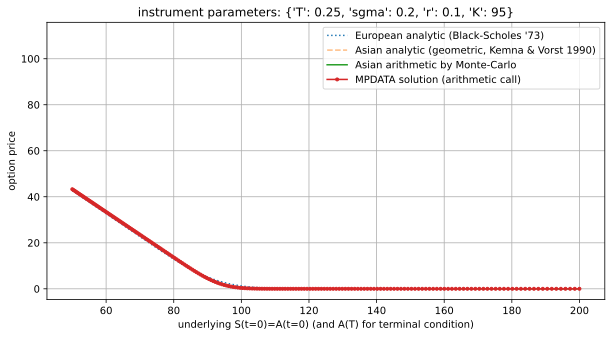

/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:413: RuntimeWarning: divide by zero encountered in divide
  abs(arithmetic_by_mc - history[frame_index][:, 0]) / arithmetic_by_mc,
/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:422: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100)


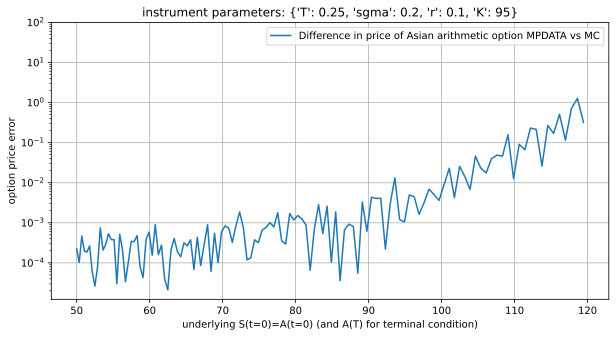

True price: 0.379
Numeric price: 0.3740327567428815
MC price: 0.3733092120408695


In [22]:
params = {
        'T': 0.25,
        'K': 95,
        'r': 0.1,
        'sgma': 0.2,
        'spot': 100,
        'true_price': 0.379,
    }
run_numeric_and_mc(params, nx=200, ny=200, nt=1000, variant='put')

self.l2=np.float64(4.8045301391820106)
CFL 0.20188539008177786
courant_x=np.float64(0.0028853900817779276), courant_y=np.float64(0.19899999999999993)
x_dim_advector.shape=(201, 200), self.a_dim_advector.shape=(200, 201)


IntProgress(value=0, max=1000)

MPDATA elapsed time: 3.062779664993286
Numeric price: 1.7168248614894328


200it [06:48,  2.04s/it]

MC elapsed time: 408.72767972946167


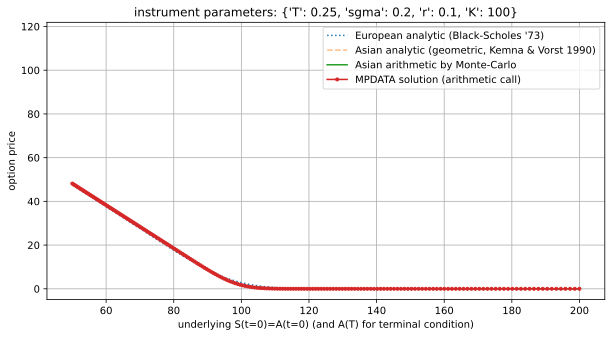

/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:413: RuntimeWarning: divide by zero encountered in divide
  abs(arithmetic_by_mc - history[frame_index][:, 0]) / arithmetic_by_mc,
/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:422: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100)


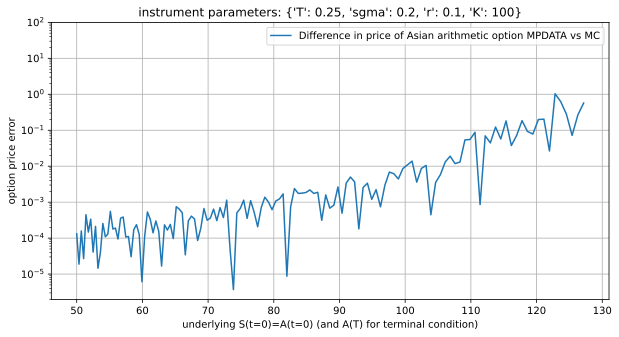

True price: 1.716
Numeric price: 1.7168248614894328
MC price: 1.7003910478009128


In [23]:
params = {
        'T': 0.25,
        'K': 100,
        'r': 0.1,
        'sgma': 0.2,
        'spot': 100,
        'true_price': 1.716,
    }
run_numeric_and_mc(params, nx=200, ny=200, nt=1000, variant='put')

self.l2=np.float64(4.8045301391820106)
CFL 0.20188539008177786
courant_x=np.float64(0.0028853900817779276), courant_y=np.float64(0.19899999999999993)
x_dim_advector.shape=(201, 200), self.a_dim_advector.shape=(200, 201)


IntProgress(value=0, max=1000)

MPDATA elapsed time: 3.274336814880371
Numeric price: 4.6072760593822935


200it [06:51,  2.06s/it]

MC elapsed time: 411.5004634857178


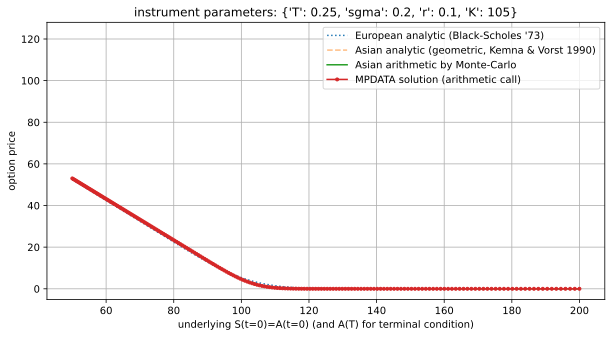

/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:413: RuntimeWarning: divide by zero encountered in divide
  abs(arithmetic_by_mc - history[frame_index][:, 0]) / arithmetic_by_mc,
/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:422: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100)


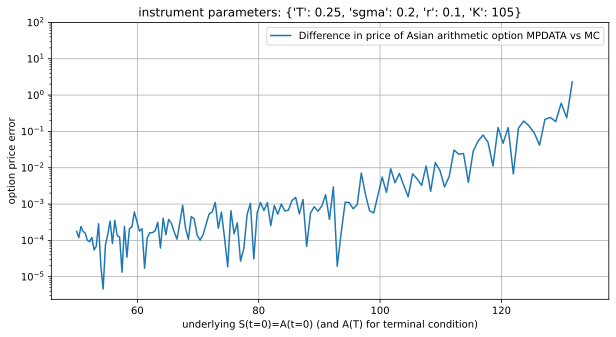

True price: 4.598
Numeric price: 4.6072760593822935
MC price: 4.591024402240118


In [24]:
params = {
        'T': 0.25,
        'K': 105,
        'r': 0.1,
        'sgma': 0.2,
        'spot': 100,
        'true_price': 4.598,
    }
run_numeric_and_mc(params, nx=200, ny=200, nt=1000, variant='put')

self.l2=np.float64(2.4022650695910053)
CFL 0.2047707801635558
courant_x=np.float64(0.005770780163555855), courant_y=np.float64(0.19899999999999993)
x_dim_advector.shape=(201, 200), self.a_dim_advector.shape=(200, 201)


IntProgress(value=0, max=1000)

MPDATA elapsed time: 5.372064113616943
Numeric price: 0.7168363286287819


200it [06:52,  2.06s/it]

MC elapsed time: 412.8026759624481


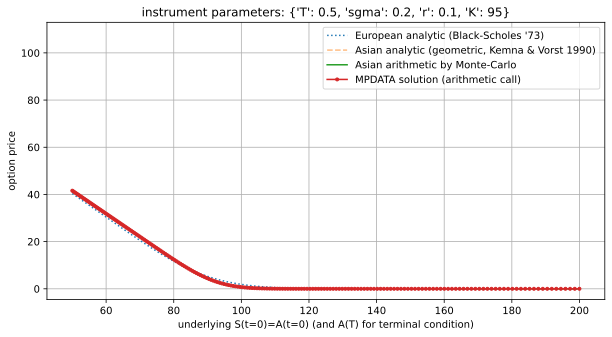

/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:413: RuntimeWarning: divide by zero encountered in divide
  abs(arithmetic_by_mc - history[frame_index][:, 0]) / arithmetic_by_mc,
/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:422: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100)


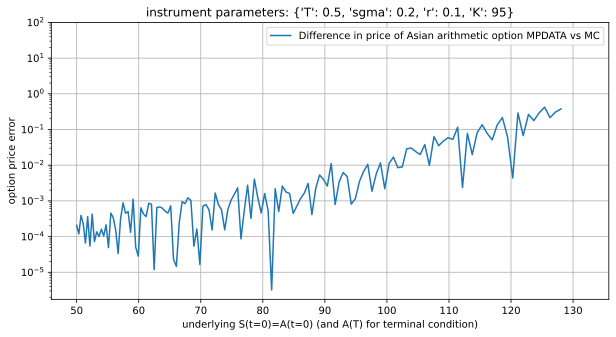

True price: 0.731
Numeric price: 0.7168363286287819
MC price: 0.7197278961738409


In [25]:
params = {
        'T': 0.5,
        'K': 95,
        'r': 0.1,
        'sgma': 0.2,
        'spot': 100,
        'true_price': 0.731,
    }
run_numeric_and_mc(params, nx=200, ny=200, nt=1000, variant='put')

self.l2=np.float64(2.4022650695910053)
CFL 0.2047707801635558
courant_x=np.float64(0.005770780163555855), courant_y=np.float64(0.19899999999999993)
x_dim_advector.shape=(201, 200), self.a_dim_advector.shape=(200, 201)


IntProgress(value=0, max=1000)

MPDATA elapsed time: 3.4919865131378174
Numeric price: 2.089890853749037


200it [06:54,  2.07s/it]

MC elapsed time: 414.0727949142456


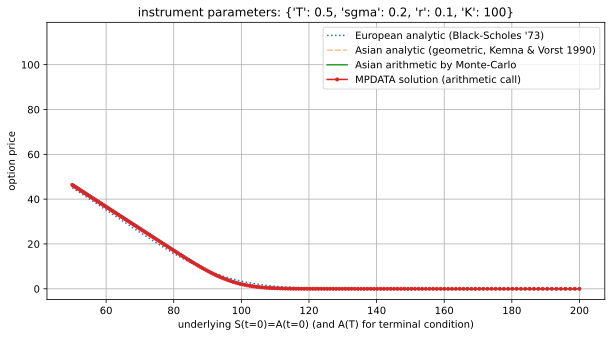

/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:413: RuntimeWarning: divide by zero encountered in divide
  abs(arithmetic_by_mc - history[frame_index][:, 0]) / arithmetic_by_mc,
/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:422: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100)


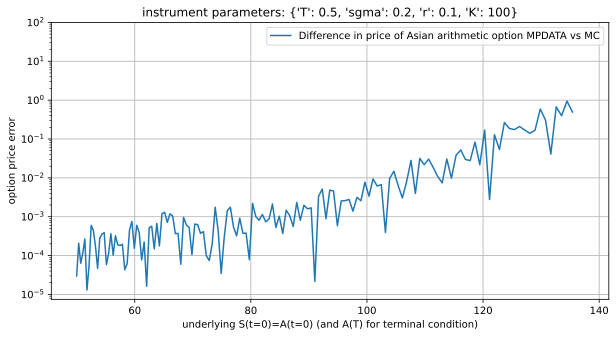

True price: 2.102
Numeric price: 2.089890853749037
MC price: 2.101859714787861


In [26]:
params = {
        'T': 0.5,
        'K': 100,
        'r': 0.1,
        'sgma': 0.2,
        'spot': 100,
        'true_price': 2.102,
    }
run_numeric_and_mc(params, nx=200, ny=200, nt=1000, variant='put')

self.l2=np.float64(2.4022650695910053)
CFL 0.2047707801635558
courant_x=np.float64(0.005770780163555855), courant_y=np.float64(0.19899999999999993)
x_dim_advector.shape=(201, 200), self.a_dim_advector.shape=(200, 201)


IntProgress(value=0, max=1000)

MPDATA elapsed time: 5.2422919273376465
Numeric price: 4.549458487332414


200it [06:55,  2.08s/it]

MC elapsed time: 415.7400801181793


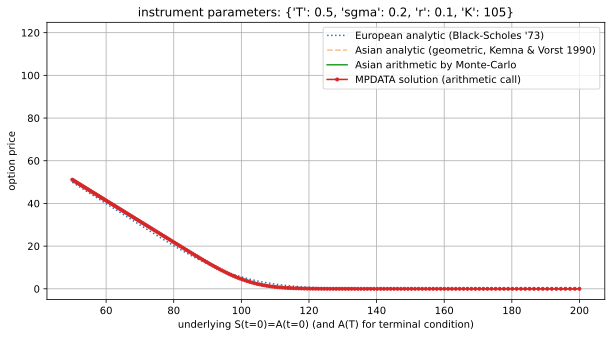

/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:413: RuntimeWarning: divide by zero encountered in divide
  abs(arithmetic_by_mc - history[frame_index][:, 0]) / arithmetic_by_mc,
/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:422: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100)


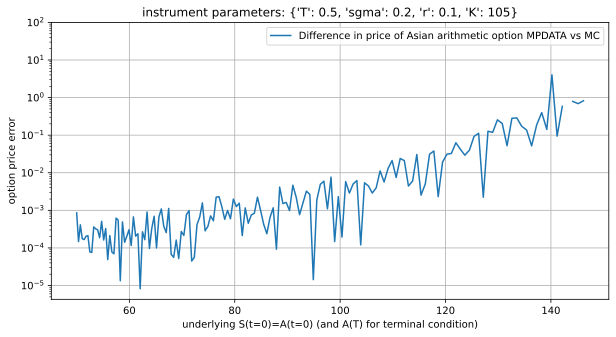

True price: 4.552
Numeric price: 4.549458487332414
MC price: 4.543542058806283


In [27]:
params = {
        'T': 0.5,
        'K': 105,
        'r': 0.1,
        'sgma': 0.2,
        'spot': 100,
        'true_price': 4.552,
    }
run_numeric_and_mc(params, nx=200, ny=200, nt=1000, variant='put')

self.l2=np.float64(4.8045301391820106)
CFL 0.05263539008177791
courant_x=np.float64(0.0028853900817779276), courant_y=np.float64(0.04974999999999998)
x_dim_advector.shape=(201, 200), self.a_dim_advector.shape=(200, 201)


IntProgress(value=0, max=4000)

MPDATA elapsed time: 13.12001085281372
Numeric price: 1.091816171172086


200it [06:49,  2.05s/it]

MC elapsed time: 409.79074001312256


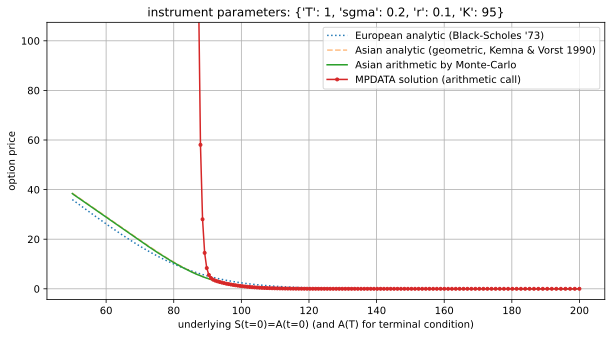

/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:413: RuntimeWarning: divide by zero encountered in divide
  abs(arithmetic_by_mc - history[frame_index][:, 0]) / arithmetic_by_mc,
/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:422: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100)


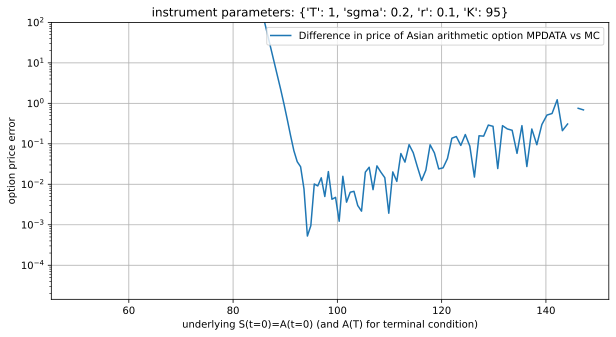

True price: 1.099
Numeric price: 1.091816171172086
MC price: 1.0952014916721646


In [30]:
params = {
        'T': 1,
        'K': 95,
        'r': 0.1,
        'sgma': 0.2,
        'spot': 100,
        'true_price': 1.099,
    }
run_numeric_and_mc(params, nx=200, ny=200, nt=4000, variant='put')

self.l2=np.float64(4.8045301391820106)
CFL 0.05263539008177791
courant_x=np.float64(0.0028853900817779276), courant_y=np.float64(0.04974999999999998)
x_dim_advector.shape=(201, 200), self.a_dim_advector.shape=(200, 201)


IntProgress(value=0, max=4000)

MPDATA elapsed time: 11.763642311096191
Numeric price: 2.3687731171065307


200it [06:51,  2.06s/it]

MC elapsed time: 411.293240070343


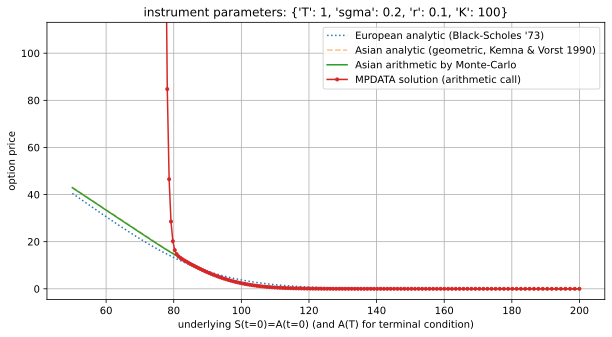

/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:413: RuntimeWarning: divide by zero encountered in divide
  abs(arithmetic_by_mc - history[frame_index][:, 0]) / arithmetic_by_mc,
/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:422: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100)


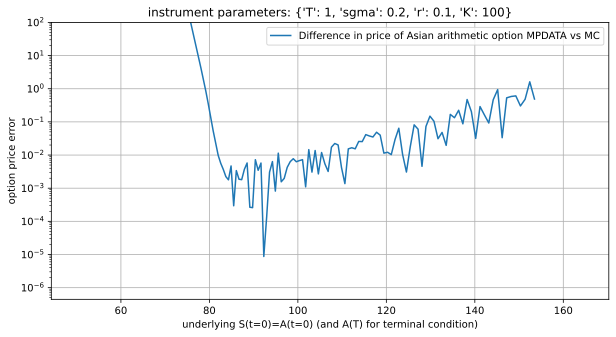

True price: 2.369
Numeric price: 2.3687731171065307
MC price: 2.3843194242655525


In [31]:
params = {
        'T': 1,
        'K': 100,
        'r': 0.1,
        'sgma': 0.2,
        'spot': 100,
        'true_price': 2.369,
    }
run_numeric_and_mc(params, nx=200, ny=200, nt=4000, variant='put')

self.l2=np.float64(9.609060278364021)
CFL 0.05238539008177791
courant_x=np.float64(0.0028853900817779276), courant_y=np.float64(0.04949999999999998)
x_dim_advector.shape=(101, 100), self.a_dim_advector.shape=(100, 101)


IntProgress(value=0, max=2000)

MPDATA elapsed time: 7.309493780136108
Numeric price: 4.384219700518613


100it [04:26,  2.66s/it]

MC elapsed time: 266.4030833244324


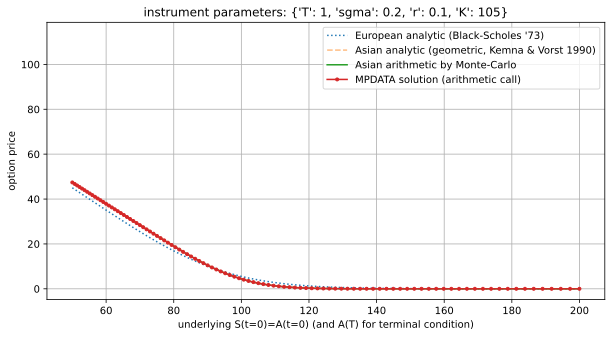

/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:413: RuntimeWarning: divide by zero encountered in divide
  abs(arithmetic_by_mc - history[frame_index][:, 0]) / arithmetic_by_mc,
/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:422: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100)


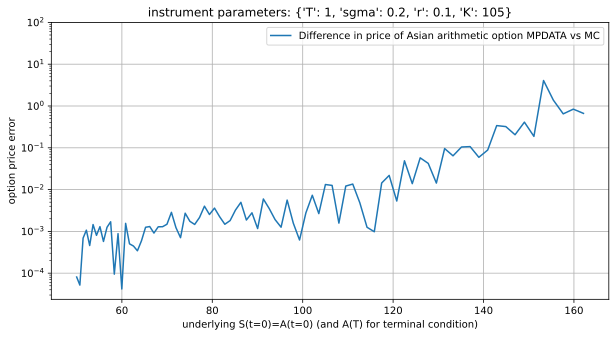

True price: 4.356
Numeric price: 4.384219700518613
MC price: 4.3771623201897985


In [36]:
params = {
        'T': 1,
        'K': 105,
        'r': 0.1,
        'sgma': 0.2,
        'spot': 100,
        'true_price': 4.356,
    }
run_numeric_and_mc(params, nx=100, ny=100, nt=2000, variant='put')

self.l2=np.float64(9.609060278364021)
CFL 0.0496803368801111
courant_x=np.float64(0.0001803368801111204), courant_y=np.float64(0.04949999999999998)
x_dim_advector.shape=(101, 100), self.a_dim_advector.shape=(100, 101)


IntProgress(value=0, max=2000)

MPDATA elapsed time: 7.278459310531616
Numeric price: 2.0304778925736913


100it [04:20,  2.60s/it]

MC elapsed time: 260.01831245422363


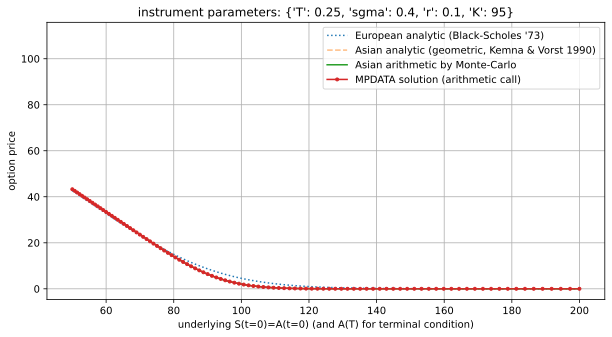

/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:413: RuntimeWarning: divide by zero encountered in divide
  abs(arithmetic_by_mc - history[frame_index][:, 0]) / arithmetic_by_mc,
/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:422: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100)


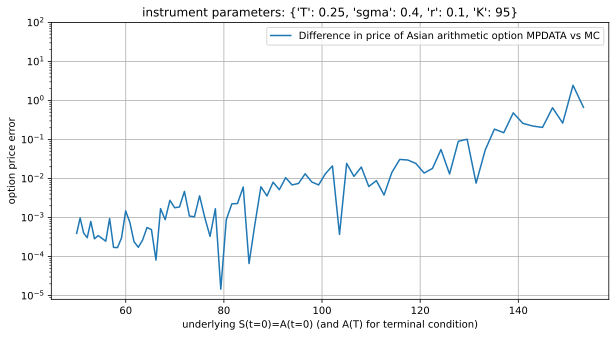

True price: 2.025
Numeric price: 2.0304778925736913
MC price: 2.0108483926750895


In [37]:
params = {
        'T': 0.25,
        'K': 95,
        'r': 0.1,
        'sgma': 0.4,
        'spot': 100,
        'true_price': 2.025,
    }
run_numeric_and_mc(params, nx=100, ny=100, nt=2000, variant='put')

self.l2=np.float64(9.609060278364021)
CFL 0.0496803368801111
courant_x=np.float64(0.0001803368801111204), courant_y=np.float64(0.04949999999999998)
x_dim_advector.shape=(101, 100), self.a_dim_advector.shape=(100, 101)


IntProgress(value=0, max=2000)

MPDATA elapsed time: 7.520007610321045
Numeric price: 3.986590613609267


100it [03:28,  2.08s/it]

MC elapsed time: 208.2283284664154


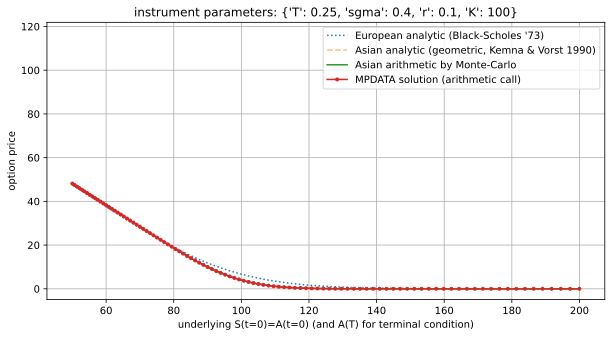

/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:413: RuntimeWarning: divide by zero encountered in divide
  abs(arithmetic_by_mc - history[frame_index][:, 0]) / arithmetic_by_mc,
/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:422: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100)


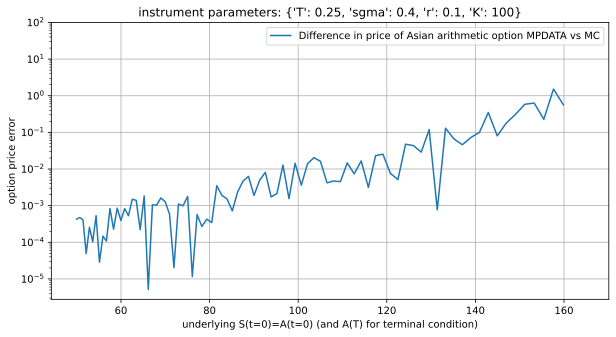

True price: 3.97
Numeric price: 3.986590613609267
MC price: 3.9496294886658645


In [38]:
params = {
        'T': 0.25,
        'K': 100,
        'r': 0.1,
        'sgma': 0.4,
        'spot': 100,
        'true_price': 3.970,
    }
run_numeric_and_mc(params, nx=100, ny=100, nt=2000, variant='put')

self.l2=np.float64(9.609060278364021)
CFL 0.0496803368801111
courant_x=np.float64(0.0001803368801111204), courant_y=np.float64(0.04949999999999998)
x_dim_advector.shape=(101, 100), self.a_dim_advector.shape=(100, 101)


IntProgress(value=0, max=2000)

MPDATA elapsed time: 8.734480857849121
Numeric price: 6.759513851662983


100it [03:25,  2.06s/it]

MC elapsed time: 205.83200311660767


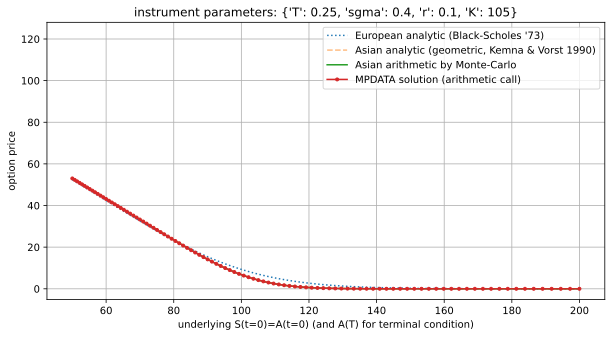

/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:413: RuntimeWarning: divide by zero encountered in divide
  abs(arithmetic_by_mc - history[frame_index][:, 0]) / arithmetic_by_mc,
/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:422: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100)


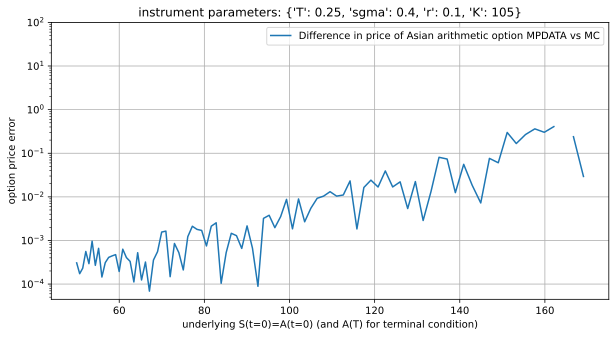

True price: 6.735
Numeric price: 6.759513851662983
MC price: 6.734118515613793


In [39]:
params = {
        'T': 0.25,
        'K': 105,
        'r': 0.1,
        'sgma': 0.4,
        'spot': 100,
        'true_price': 6.735,
    }
run_numeric_and_mc(params, nx=100, ny=100, nt=2000, variant='put')

self.l2=np.float64(4.8045301391820106)
CFL 0.04986067376022222
courant_x=np.float64(0.0003606737602222408), courant_y=np.float64(0.04949999999999998)
x_dim_advector.shape=(101, 100), self.a_dim_advector.shape=(100, 101)


IntProgress(value=0, max=2000)

MPDATA elapsed time: 5.330230474472046
Numeric price: 3.2105192313337465


100it [04:18,  2.58s/it]

MC elapsed time: 258.2690587043762


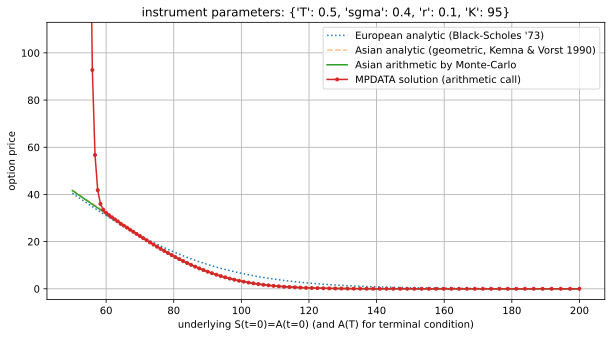

/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:413: RuntimeWarning: divide by zero encountered in divide
  abs(arithmetic_by_mc - history[frame_index][:, 0]) / arithmetic_by_mc,
/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:422: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100)


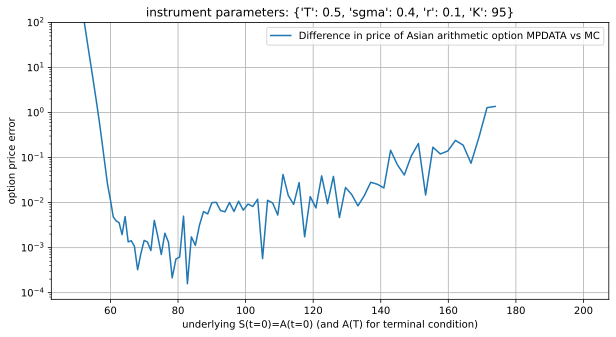

True price: 3.215
Numeric price: 3.2105192313337465
MC price: 3.1851930496141225


In [40]:
params = {
        'T': 0.5,
        'K': 95,
        'r': 0.1,
        'sgma': 0.4,
        'spot': 100,
        'true_price': 3.215,
    }
run_numeric_and_mc(params, nx=100, ny=100, nt=2000, variant='put')

self.l2=np.float64(4.8045301391820106)
CFL 0.04986067376022222
courant_x=np.float64(0.0003606737602222408), courant_y=np.float64(0.04949999999999998)
x_dim_advector.shape=(101, 100), self.a_dim_advector.shape=(100, 101)


IntProgress(value=0, max=2000)

MPDATA elapsed time: 5.508124113082886
Numeric price: 5.1993683015073335


100it [03:25,  2.05s/it]

MC elapsed time: 205.24198007583618


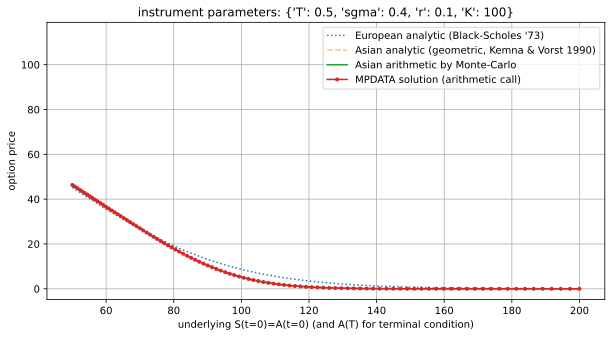

/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:413: RuntimeWarning: divide by zero encountered in divide
  abs(arithmetic_by_mc - history[frame_index][:, 0]) / arithmetic_by_mc,
/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:422: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100)


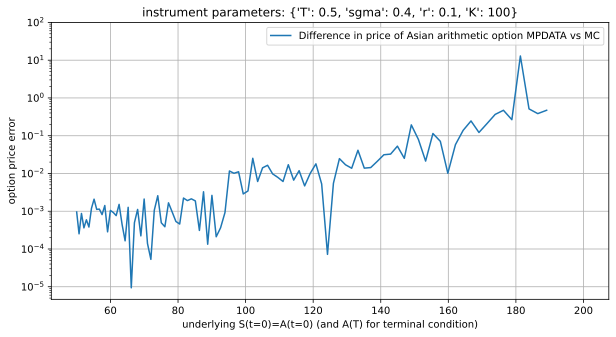

True price: 5.197
Numeric price: 5.1993683015073335
MC price: 5.183080870225042


In [41]:
params = {
        'T': 0.5,
        'K': 100,
        'r': 0.1,
        'sgma': 0.4,
        'spot': 100,
        'true_price': 5.197,
    }

run_numeric_and_mc(params, nx=100, ny=100, nt=2000, variant='put')

self.l2=np.float64(4.8045301391820106)
CFL 0.04986067376022222
courant_x=np.float64(0.0003606737602222408), courant_y=np.float64(0.04949999999999998)
x_dim_advector.shape=(101, 100), self.a_dim_advector.shape=(100, 101)


IntProgress(value=0, max=2000)

MPDATA elapsed time: 5.683553457260132
Numeric price: 7.757526964435898


100it [03:27,  2.07s/it]

MC elapsed time: 207.13279509544373


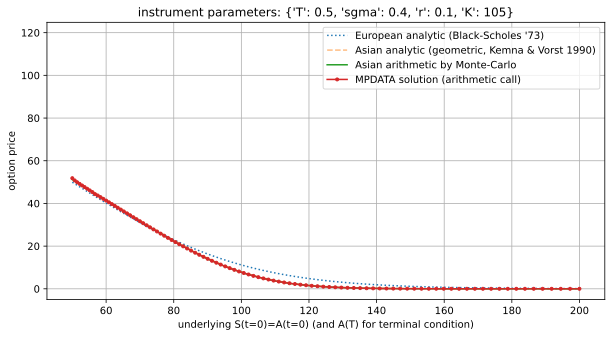

/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:422: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100)


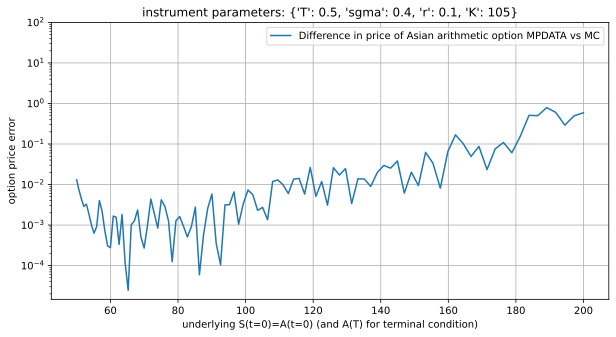

True price: 7.748
Numeric price: 7.757526964435898
MC price: 7.71713657467501


In [42]:
params = {
        'T': 0.5,
        'K': 105,
        'r': 0.1,
        'sgma': 0.4,
        'spot': 100,
        'true_price': 7.748,
    }
run_numeric_and_mc(params, nx=100, ny=100, nt=2000, variant='put')

self.l2=np.float64(2.906740734205117)
CFL 0.04150524588466484
courant_x=np.float64(0.0005961549755739516), courant_y=np.float64(0.04090909090909089)
x_dim_advector.shape=(101, 100), self.a_dim_advector.shape=(100, 101)


IntProgress(value=0, max=2420)

MPDATA elapsed time: 7.470585584640503
Numeric price: 4.5385899957267295


100it [03:25,  2.06s/it]

MC elapsed time: 205.91660904884338


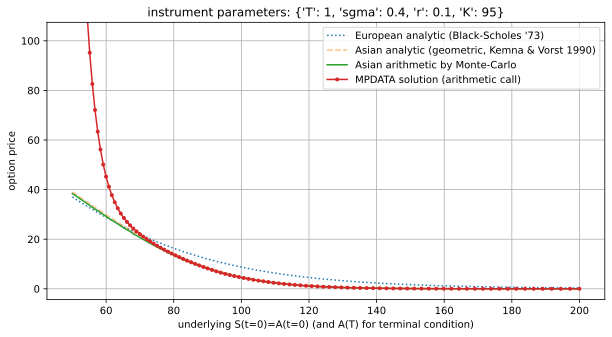

/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:422: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100)


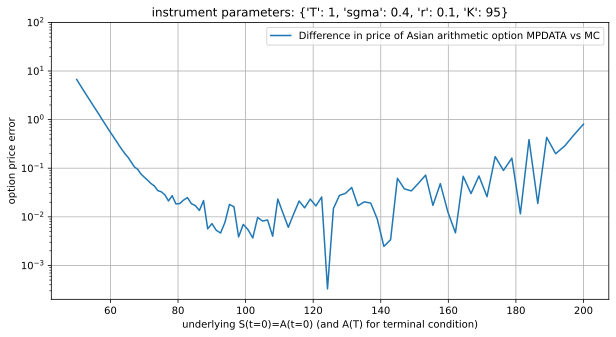

True price: 4.55
Numeric price: 4.5385899957267295
MC price: 4.510373825622241


In [53]:
params = {
        'T': 1,
        'K': 95,
        'r': 0.1,
        'sgma': 0.4,
        'spot': 100,
        'true_price': 4.550,
    }
run_numeric_and_mc(params, nx=100, ny=100, nt=2420, variant='put')

self.l2=np.float64(2.762604830029656)
CFL 0.04367073697429953
courant_x=np.float64(0.0006272587134299839), courant_y=np.float64(0.043043478260869544)
x_dim_advector.shape=(101, 100), self.a_dim_advector.shape=(100, 101)


IntProgress(value=0, max=2300)

MPDATA elapsed time: 6.921475172042847
Numeric price: 6.64812954364324


100it [03:27,  2.07s/it]

MC elapsed time: 207.30976152420044


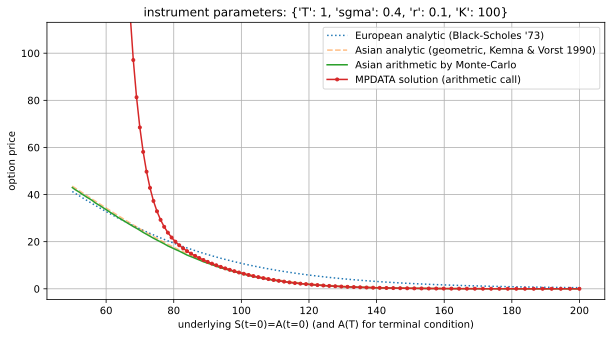

/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:422: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100)


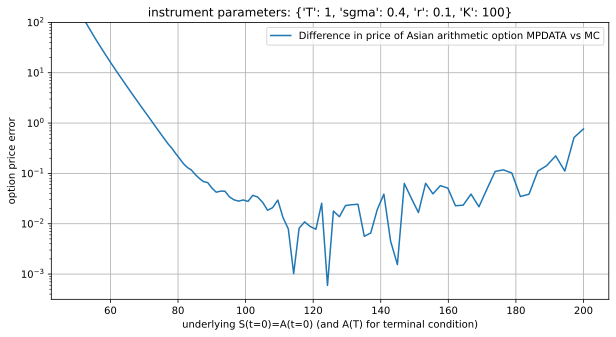

True price: 6.465
Numeric price: 6.64812954364324
MC price: 6.462341731633215


In [55]:
params = {
        'T': 1,
        'K': 100,
        'r': 0.1,
        'sgma': 0.4,
        'spot': 100,
        'true_price': 6.465,
    }
run_numeric_and_mc(params, nx=100, ny=100, nt=2300, variant='put')

self.l2=np.float64(3.122944590468307)
CFL 0.03863180578495727
courant_x=np.float64(0.0005548827080342166), courant_y=np.float64(0.03807692307692306)
x_dim_advector.shape=(101, 100), self.a_dim_advector.shape=(100, 101)


IntProgress(value=0, max=2600)

MPDATA elapsed time: 8.134722471237183
Numeric price: 8.812782369694158


100it [03:25,  2.06s/it]

MC elapsed time: 205.79937505722046


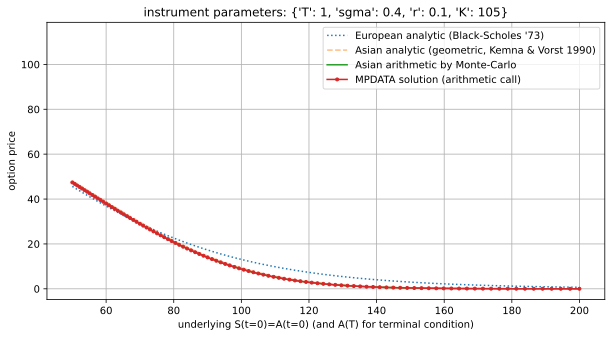

/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:422: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100)


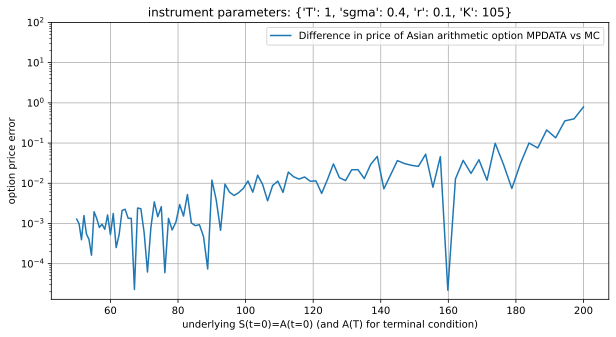

True price: 8.767
Numeric price: 8.812782369694158
MC price: 8.73132536932032


In [57]:
params = {
        'T': 1,
        'K': 105,
        'r': 0.1,
        'sgma': 0.4,
        'spot': 100,
        'true_price': 8.767,
    }
run_numeric_and_mc(params, nx=100, ny=100, nt=2600, variant='put')

In [71]:
def plot_solution(
    settings,
    frame_index,
    ax,
    history,
    S_linspace,
    arithmetic_by_mc,
    arithmetic_by_mc_std,
    option_type: str,
    variant,
    A_space,
    S_space
):
    params = {
        k: v for k, v in settings.params.__dict__.items() if not k.startswith("K")
    }
    if variant == "call":
        BS_price_func = Black_Scholes_1973.c_euro
        Amer_price_func = Bjerksund_and_Stensland_1993.c_amer
        geometric_price_func = asian_analytic.geometric_asian_average_price_c
    else:
        BS_price_func = Black_Scholes_1973.p_euro
        Amer_price_func = Bjerksund_and_Stensland_1993.p_amer
        geometric_price_func = asian_analytic.geometric_asian_average_price_p
    range_lower, range_upper = 80, 120
    s_indexes_within_range = [i for i, v in enumerate(S_linspace) if range_lower<=v<=range_upper]
    # s_indexes_within_range = [i for i, v in enumerate(S_linspace)]
    ax.plot(
        S_linspace[s_indexes_within_range],
        (
            BS_price_func(
                S=S_linspace[s_indexes_within_range], K=settings.params.K, **params, b=settings.params.r
            )
        ),
        label="European analytic (Black-Scholes '73)",
        linestyle="--",
        alpha=0.5,
        c="black"
    )
    # ax.plot(
    #     S_linspace,
    #     (
    #         Amer_price_func(
    #             S=S_linspace, K=settings.params.K, **params, b=settings.params.r
    #         )
    #     ),
    #     label="American analytic (Bjerksund & Stensland '93)", linestyle='--'
    # )
    
    # print(settings.rh[:-1].shape)
    # print(history[frame_index][0,:].shape)
    ax.bar(
        S_space[:-1][s_indexes_within_range],
        history[frame_index][:, 0][s_indexes_within_range],
        width=S_space[1:][s_indexes_within_range] - S_space[:-1][s_indexes_within_range],
        # label=f"MPDATA solution ({option_type})",
        alpha=0.3,
        align="edge",
        color="orange"
    )
    # ax.bar(
    #     settings.rh[:-1],
    #     history[0][0,:],
    #     width=settings.rh[1:] - settings.rh[:-1],
    #     label=f"Terminal condition (discounted payoff)",
    #     alpha=0.5,
    #     align="edge"
    # )
    ax.plot(
        S_linspace[s_indexes_within_range],
        history[frame_index][:, 0][s_indexes_within_range],
        label=f"Asian arithmetic MPDATA solution",
        marker=".",
        # alpha=0.7,
        c="orange"
    )
    
    ax.plot(
        S_linspace[s_indexes_within_range],
        arithmetic_by_mc[s_indexes_within_range],
        # arithmetic_by_mc_std[s_indexes_within_range],
        label="Asian arithmetic by Monte-Carlo",
        # linestyle=":",
        marker="+",
        # alpha=0.5,
        c="blue"
    )
    ax.plot(
        S_linspace[s_indexes_within_range],
        (
            geometric_price_func(
                S=S_linspace[s_indexes_within_range], K=settings.params.K, **params, dividend_yield=0
            )
        ),
        label="Asian geometric analytic (Kemna & Vorst 1990)",
        # alpha=0.5,
        linestyle="--",
        c="green"
    )
    # ax.plot(
    #     A_space,
    #     history[0][0, :],
    #     label=f"Terminal condition (discounted payoff)",
    #     marker=".",
    #     alpha=0.5,
    # )
    ax2 = ax.twinx()
    # on ax2 plot discretized ticks x/Δx
    ax2.set_xticks(np.arange(0, len(settings.rh), 5))
    ax.legend(loc="upper left")
    ax.grid()
    minmax = (np.amin(history[0]), np.amax(history[0]))
    span = minmax[1] - minmax[0]
    # ax.set_ylim(minmax[0] - 0.05 * span, minmax[1] + 0.25 * span)
    # ax.set_title(f"Asian option valuation for: {settings.params.__dict__}")
    # ax.set_xlabel("underlying S(t=0)=A(t=0) (and A(T) for terminal condition)")
    # ax.set_xlabel("average at t=T for payoff, spot at t=0 for other datasets")
    ax.set_xlabel("spot price at t=0 ($)")
    ax.set_ylabel("instrument value ($)")

self.l2=13.618282707432003
CFL 0.05999999999999997
courant_x=4.20449728625708e-19, courant_y=0.05999999999999997
x_dim_advector.shape=(22, 31), self.a_dim_advector.shape=(21, 32)


IntProgress(value=0, max=500)

MPDATA elapsed time: 6.000473976135254
Numeric price: 11.590865261368332


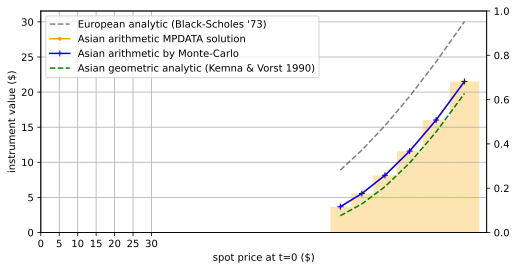

True price: 8.767
Numeric price: 11.590865261368332


In [74]:
params = {
        'T': 1,
        'K': 100,
        'r': 0.08,
        'sgma': 0.4,
        'spot': 100,
        'true_price': 8.767,
    }
run_numeric_and_mc(params, nx=21, ny=31, nt=500, variant='call')

self.l2=13.618282707432003
CFL 0.05999999999999997
courant_x=4.20449728625708e-19, courant_y=0.05999999999999997
x_dim_advector.shape=(22, 31), self.a_dim_advector.shape=(21, 32)


IntProgress(value=0, max=500)

MPDATA elapsed time: 5.8242504596710205
Numeric price: 11.590816454795288


21it [00:57,  2.75s/it]


MC elapsed time: 57.6473867893219


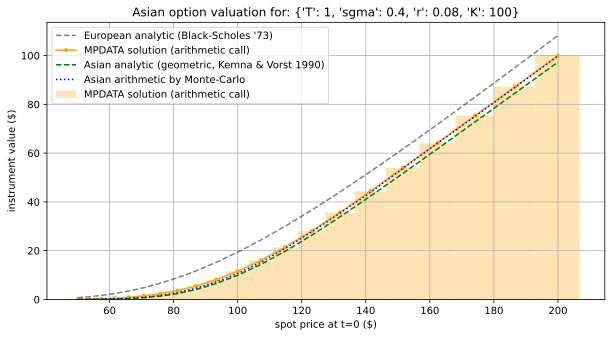

True price: 8.767
Numeric price: 11.590816454795288


In [40]:
params = {
        'T': 1,
        'K': 100,
        'r': 0.08,
        'sgma': 0.4,
        'spot': 100,
        'true_price': 8.767,
    }
run_numeric_and_mc(params, nx=21, ny=31, nt=500, variant='call')

self.l2=27.236565414864007
CFL 0.029999999999999985
courant_x=2.10224864312854e-19, courant_y=0.029999999999999985
x_dim_advector.shape=(22, 31), self.a_dim_advector.shape=(21, 32)


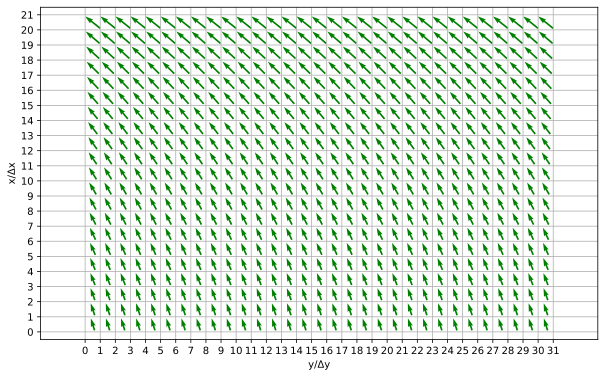

In [69]:
settings = Settings(T=params['T'], K=params['K'], r=params['r'], sgma=params['sgma'], S_max=200, S_min=50)
simulation = AsianArithmetic(settings, nx=21, ny=31, nt=1000, variant="call")

fig, ax = pyplot.subplots(1, 1, figsize=(10,6))
X = simulation.solver.advector.get_component(0)[:-1,:]
Y = simulation.solver.advector.get_component(1)[:,:-1]
grid = (X.shape[1], Y.shape[0])
scale_x, scale_y = np.amax(np.abs(X)), np.amax(np.abs(Y))
ax.quiver(*np.mgrid[
        1/2 : grid[0] : 1,
        1/2: grid[1] : 1,
    ], Y.T.flatten()/0.8/scale_y, X.T.flatten()/scale_x, pivot='mid', color='green', width=.003,
    label='price advector values at cell centers', scale=6, scale_units='inches'
)

ax.axis('equal')
# ax.set_title("resulting advector values at cell centers fo Asian arithmetic call option")
ax.set_xlabel('y/Δy')
ax.set_ylabel('x/Δx')
# ax.legend(bbox_to_anchor=(.1, -.1), loc='upper left', ncol=1)
for i, xy in enumerate(('x', 'y')):
    getattr(ax, f"set_{xy}ticks")(np.arange(0, grid[i] + 1))
ax.grid()
show_plot('asian_arithmetic_advector.pdf')

self.l2=13.618282707432003
CFL 0.05999999999999997
courant_x=4.20449728625708e-19, courant_y=0.05999999999999997
x_dim_advector.shape=(22, 31), self.a_dim_advector.shape=(21, 32)


TypeError: FigureBase.colorbar() missing 1 required positional argument: 'mappable'

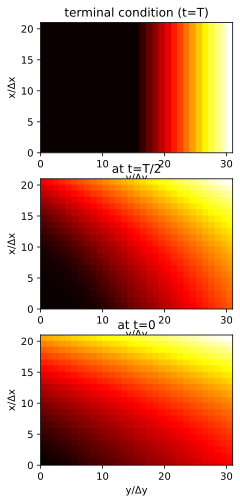

In [61]:
settings = Settings(T=params['T'], K=params['K'], r=params['r'], sgma=params['sgma'], S_max=200, S_min=50)
simulation = AsianArithmetic(settings, nx=21, ny=31, nt=500, variant="call")

history = [simulation.solver.advectee.get().copy()]
for i in range(500):
    res = simulation.step()
history.append(simulation.solver.advectee.get().copy())
for i in range(500):
    res = simulation.step()
history.append(simulation.solver.advectee.get().copy())

fig, ax = pyplot.subplots(3, 1, figsize=(10,8))

ax[0].imshow(history[0], cmap='hot', interpolation='nearest', origin='lower', extent=(0, 31, 0, 21))
ax[0].set_title("terminal condition (t=T)")
ax[1].imshow(history[1], cmap='hot', interpolation='nearest', origin='lower', extent=(0, 31, 0, 21))
ax[1].set_title("at t=T/2")
ax[2].imshow(history[2], cmap='hot', interpolation='nearest', origin='lower', extent=(0, 31, 0, 21))
ax[2].set_title("at t=0")

ax[0].set_xlabel('y/Δy')
ax[1].set_xlabel('y/Δy')
ax[2].set_xlabel('y/Δy')
ax[0].set_ylabel('x/Δx')
ax[1].set_ylabel('x/Δx')
ax[2].set_ylabel('x/Δx')

fig.colorbar(ax=ax[0], shrink=0.8, label='price advectee values at cell centers')

# add colorbar

fig.tight_layout()

show_plot('advectee_over_time.pdf')